In [42]:
import torch
import torch.nn as nn 

import numpy as np
import pandas as pd

from monai.transforms import (
                            Compose,
                            LoadImaged,
                            EnsureChannelFirstd,
                            EnsureTyped,
                            ScaleIntensityRangePercentilesD,
                            Orientationd,
                            CropForegroundd, 
                            OneOf,
                            RandCropByPosNegLabeld,
                            RandSpatialCropd,
                            RandFlipd,
                            RandShiftIntensityd,
                            ScaleIntensityRanged
                        )

import glob
import matplotlib.pyplot as plt

In [68]:
data_dir = '/root/Competitions/MICCAI/AutoPET2023/data/train'
meta_df = pd.read_csv('/root/Competitions/MICCAI/AutoPET2023/data/Metadata-FDG_PET_CT.csv')
meta_df = meta_df[meta_df['SOP Class Name'] == 'Segmentation Storage'] # to remove the redundancy path
file_paths = meta_df['File Location'].apply(lambda x: '/'.join([data_dir] + x.split('/')[2:4])) # Even faster 

df = pd.DataFrame(columns=['img_path', 'diagnosis'])
df['img_path'] = file_paths
df['diagnosis'] = meta_df.diagnosis

In [69]:
target = df.img_path.iloc[0]
print(f'diagnosis: {df.iloc[0].diagnosis}, {target}')

diagnosis: MELANOMA, /root/Competitions/MICCAI/AutoPET2023/data/train/PETCT_0011f3deaf/03-23-2003-NA-PET-CT Ganzkoerper  primaer mit KM-10445


In [100]:
all_keys = ['image','label']
default_transform = Compose([
                        LoadImaged(keys=all_keys, ensure_channel_first=True),
                        EnsureTyped(keys=all_keys, data_type='tensor', track_meta=False)
])

origind = {'image':f'{target}/CTres.nii.gz',
          'label':f'{target}/SEG.nii.gz'}

origin = default_transform(origind)

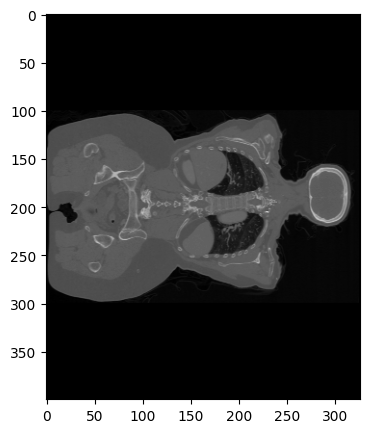

In [74]:
plt.figure(figsize=(5,5))
plt.imshow(origin['image'][0][:, 170, :].detach().cpu(), cmap='gray')

before crop:  torch.Size([400, 400, 326])
after crop:  torch.Size([200, 200, 325])


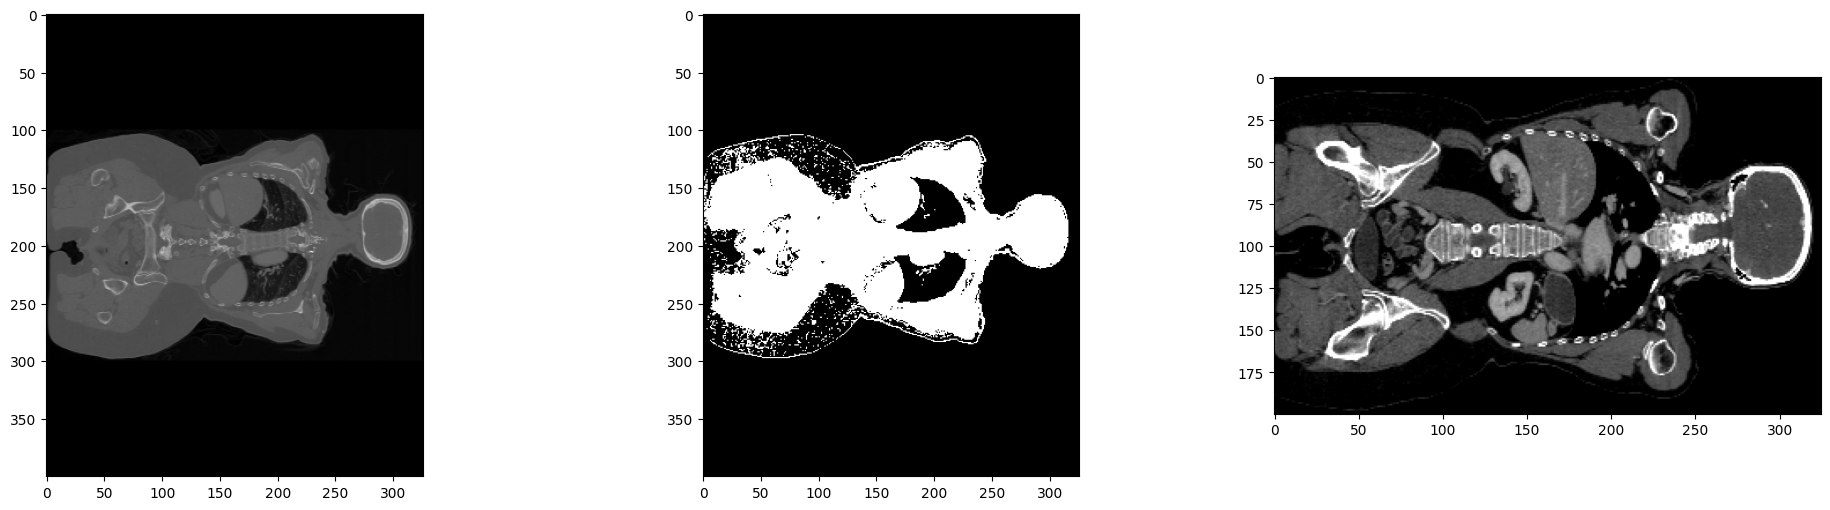

In [75]:
norm = ScaleIntensityRanged(keys='image', a_min=-100, a_max=400, b_min=0, b_max=1, clip=True)

normed = norm(origin)
plt.figure("image", (24,6))
plt.subplot(1, 3, 1)
plt.imshow(origin['image'][0][:, 170, :].detach().cpu(), cmap='gray')

bg = torch.where(normed['image'][0] == 0, 0, 1)
plt.subplot(1, 3, 2)
plt.imshow(bg[:, 170, :].detach().cpu(), cmap='gray')

print('before crop: ',bg.shape)
foreg_crop = CropForegroundd(keys=all_keys, source_key='image')
cropped = foreg_crop(normed)
print('after crop: ', cropped['image'][0].shape)
plt.subplot(1, 3, 3)

plt.imshow(cropped['image'][0][:, 170//2, :].detach().cpu(), cmap='gray')


torch.Size([200, 200, 325])


/tmp/ipykernel_588847/3496418241.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(24,6))


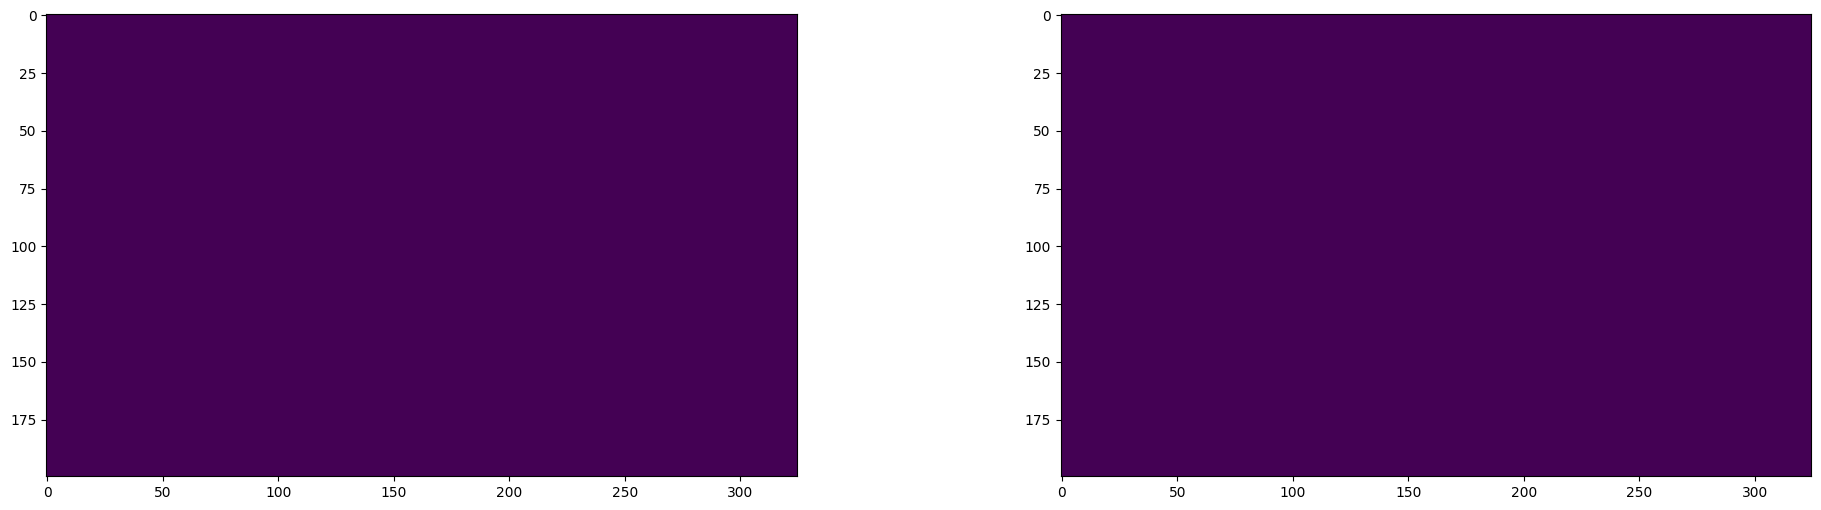

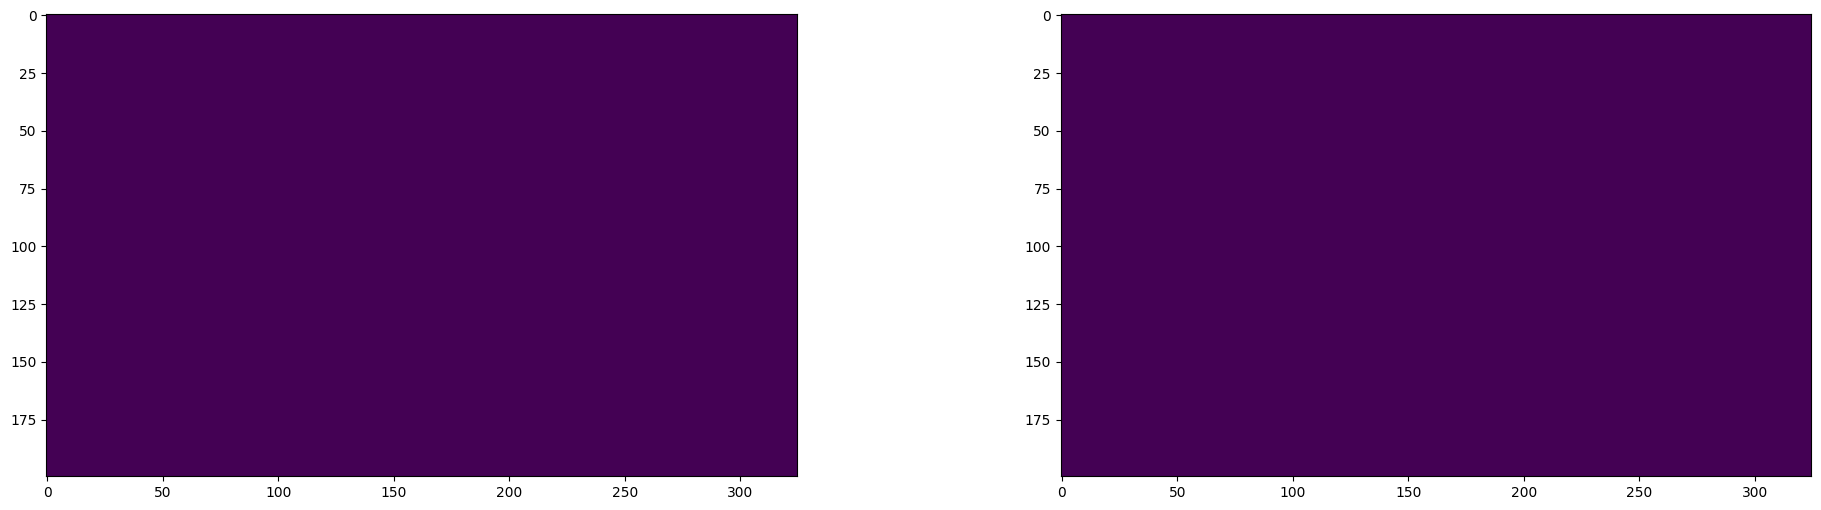

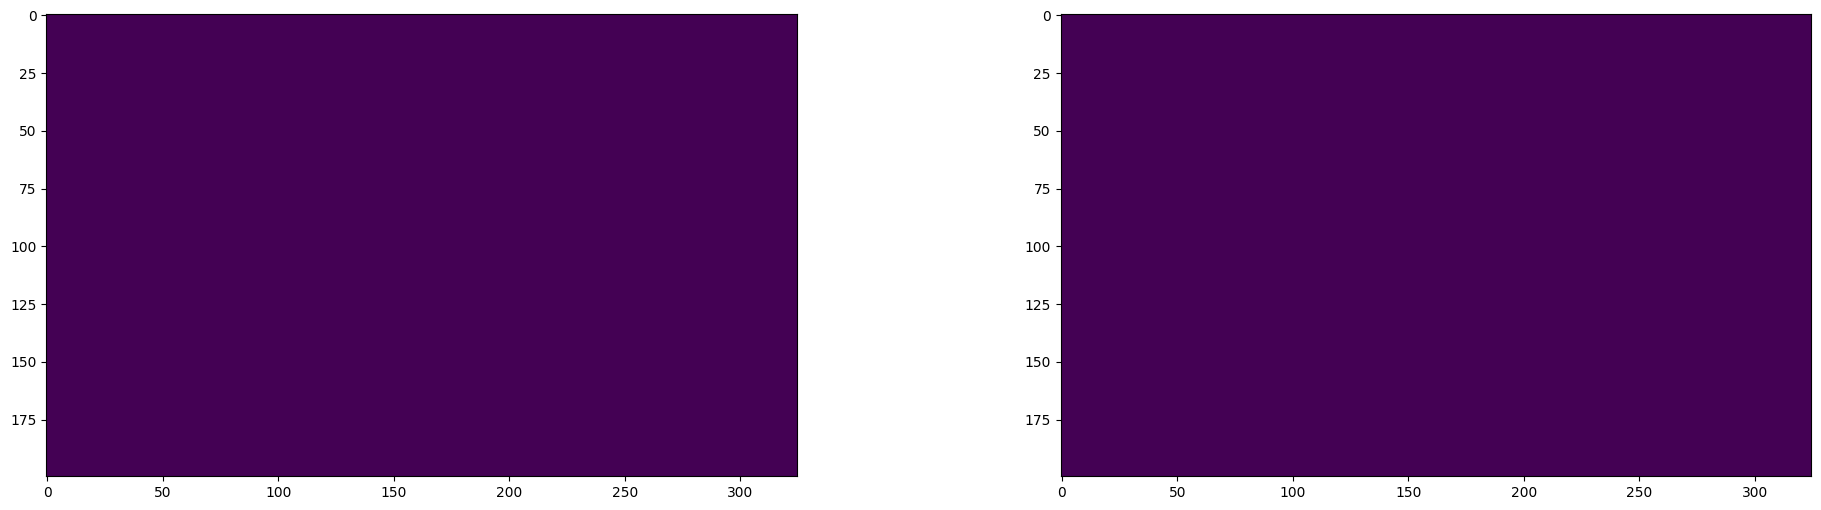

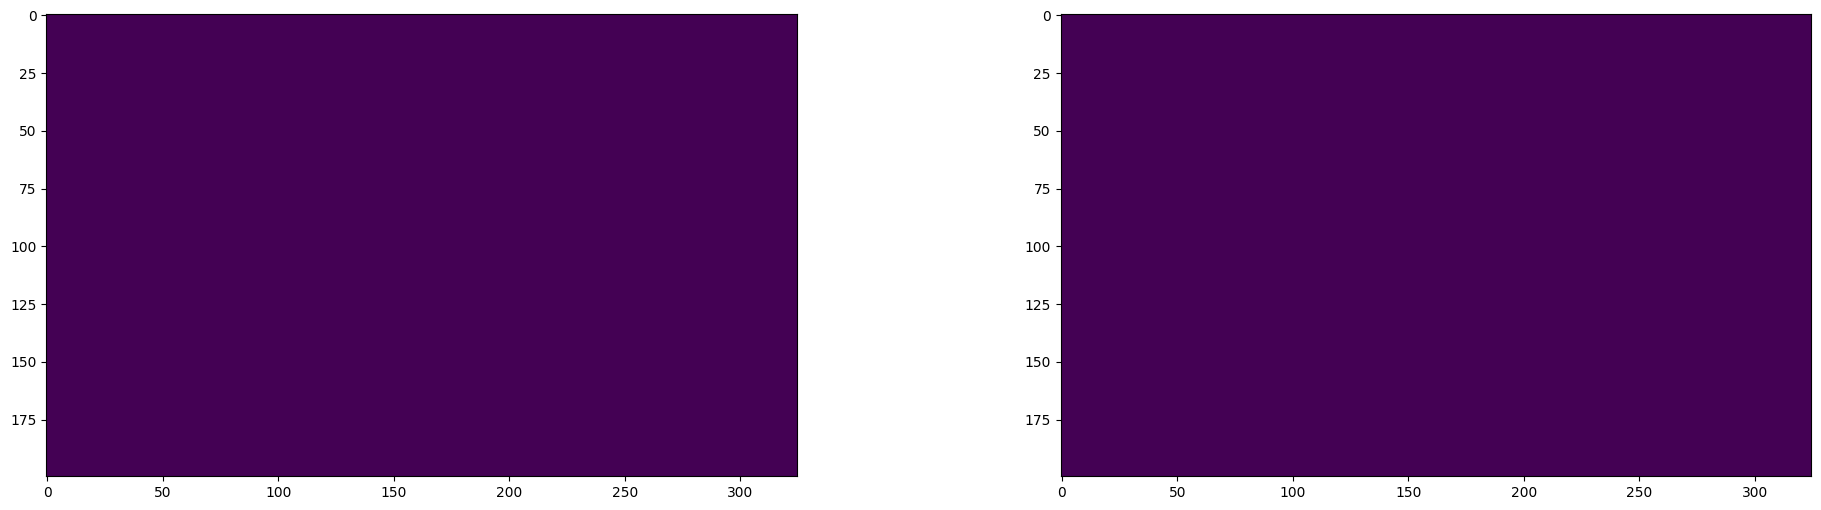

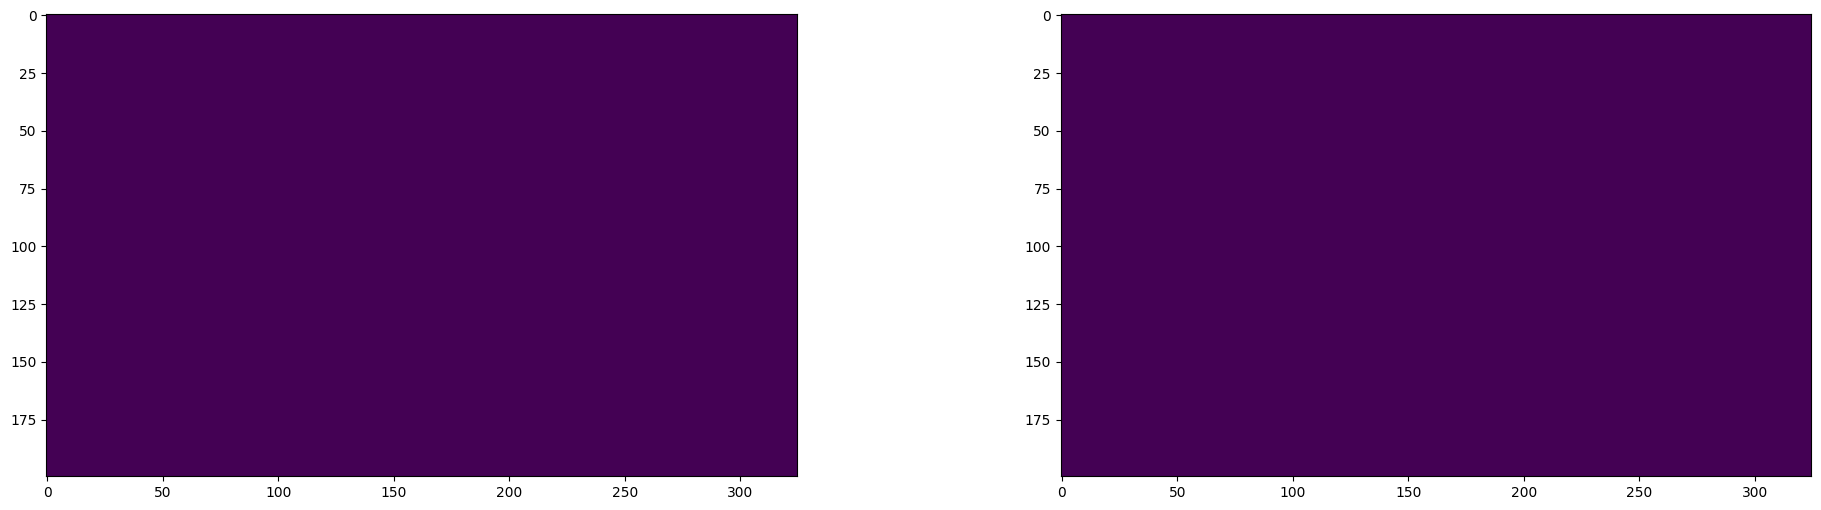

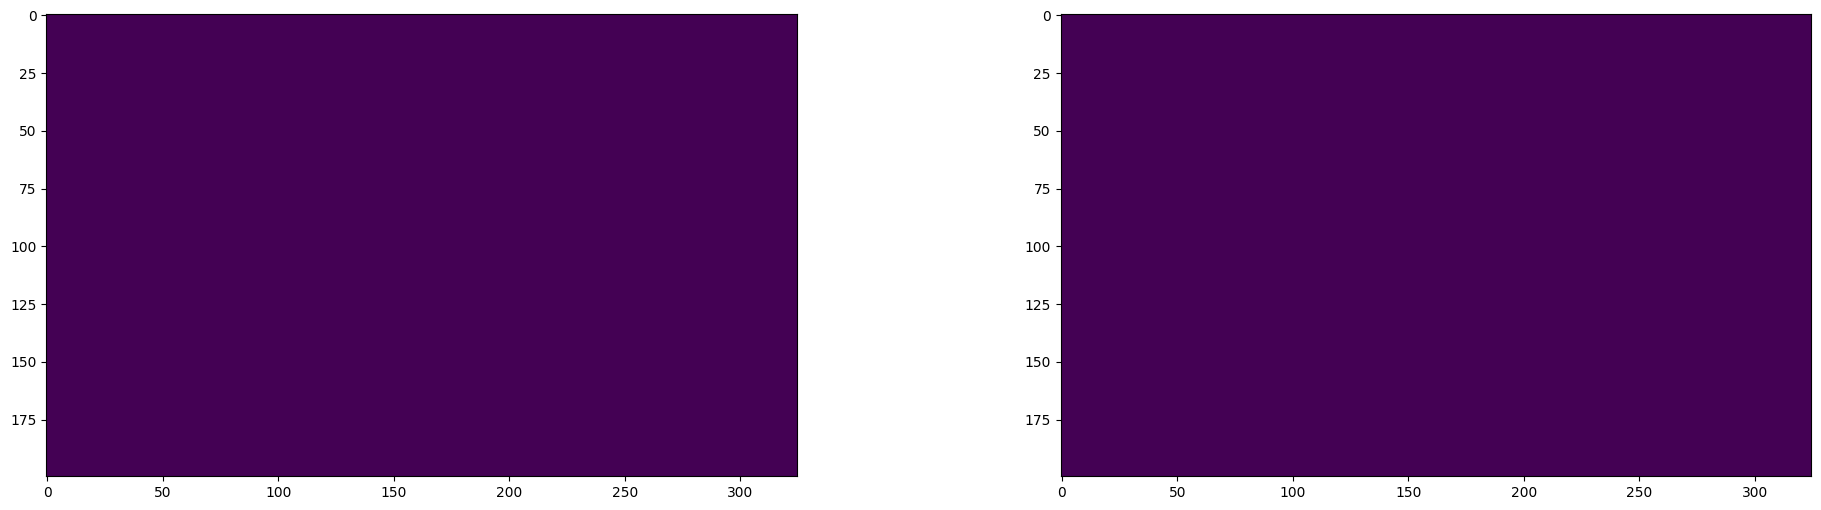

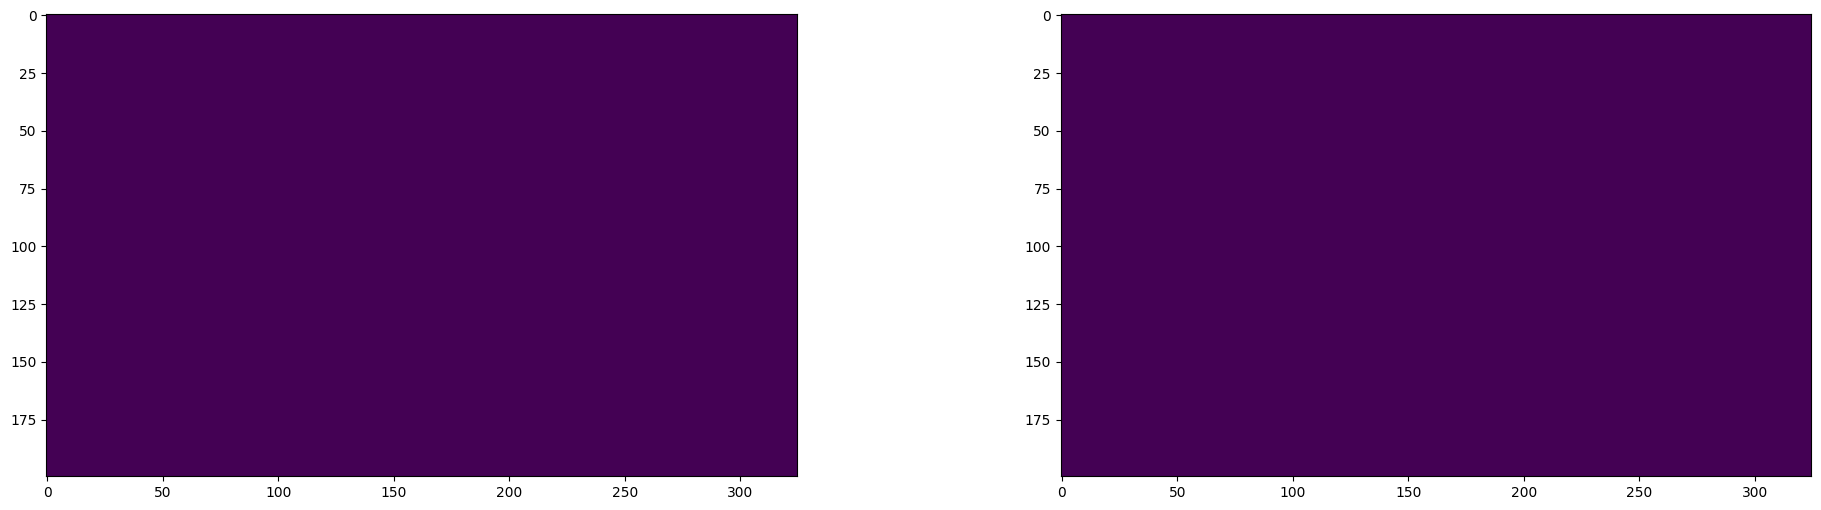

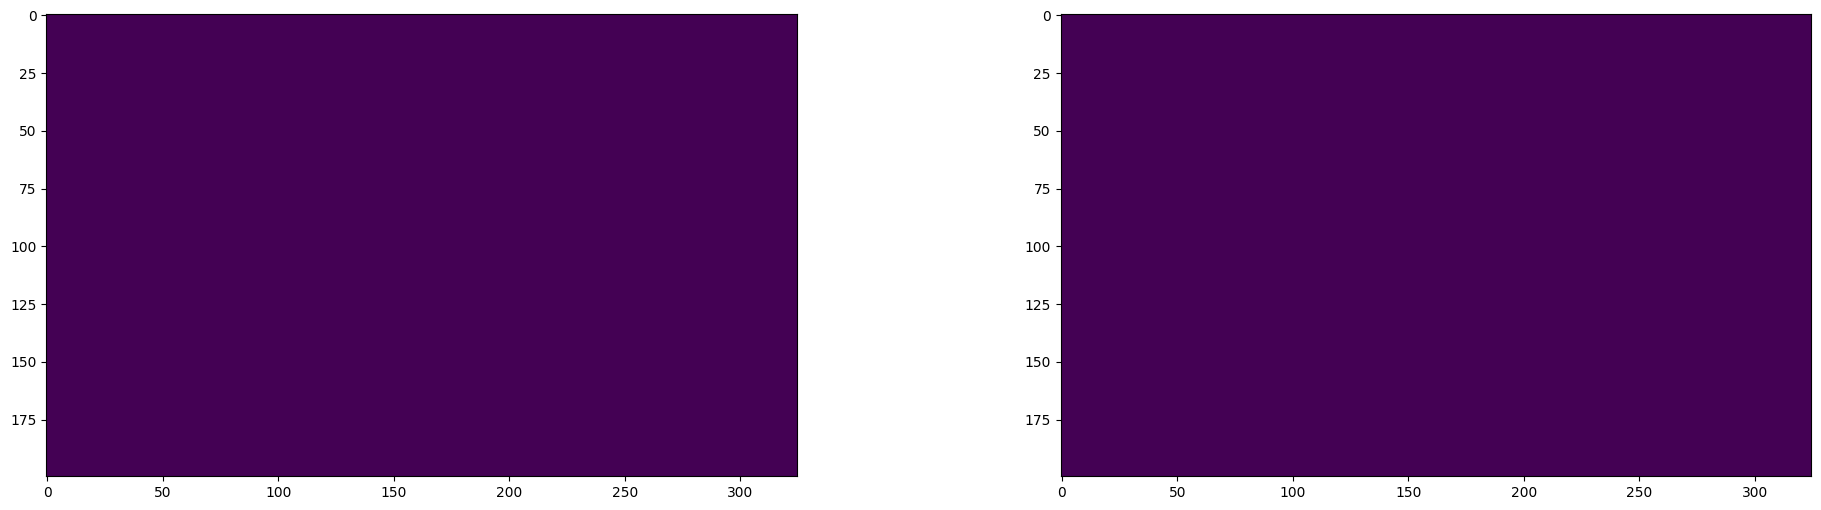

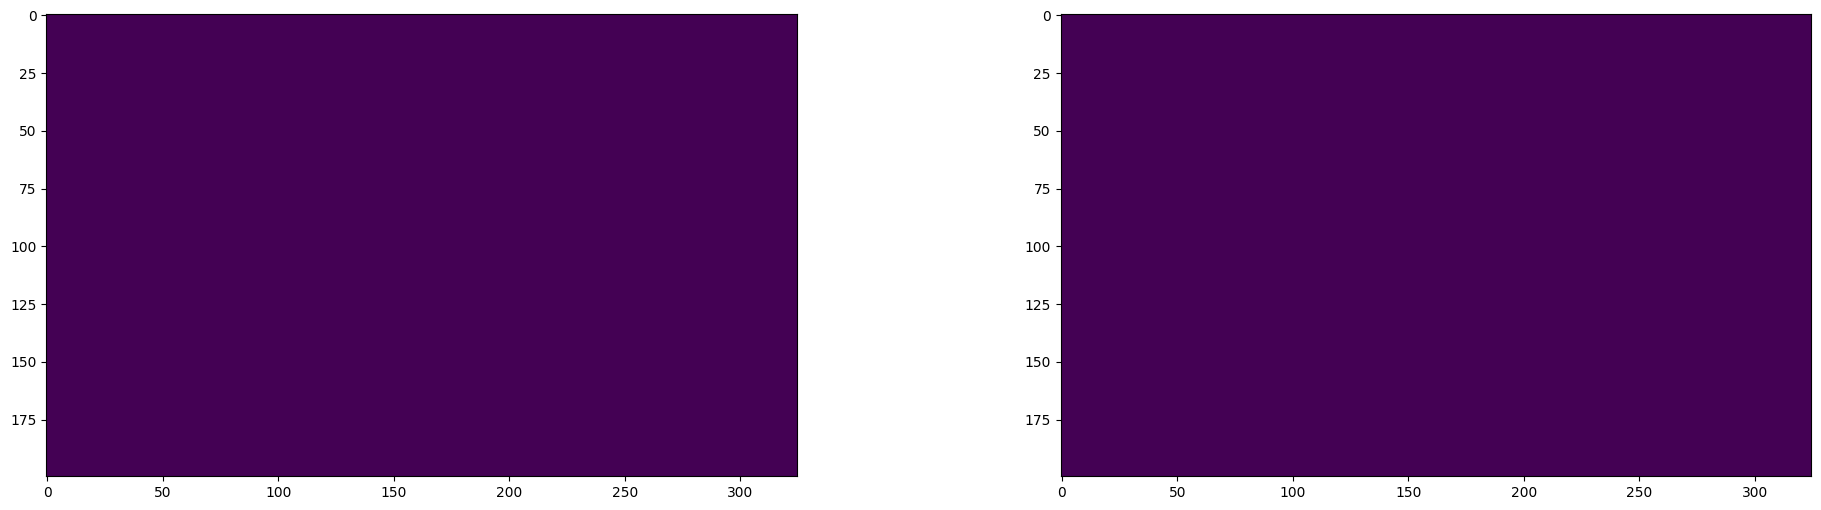

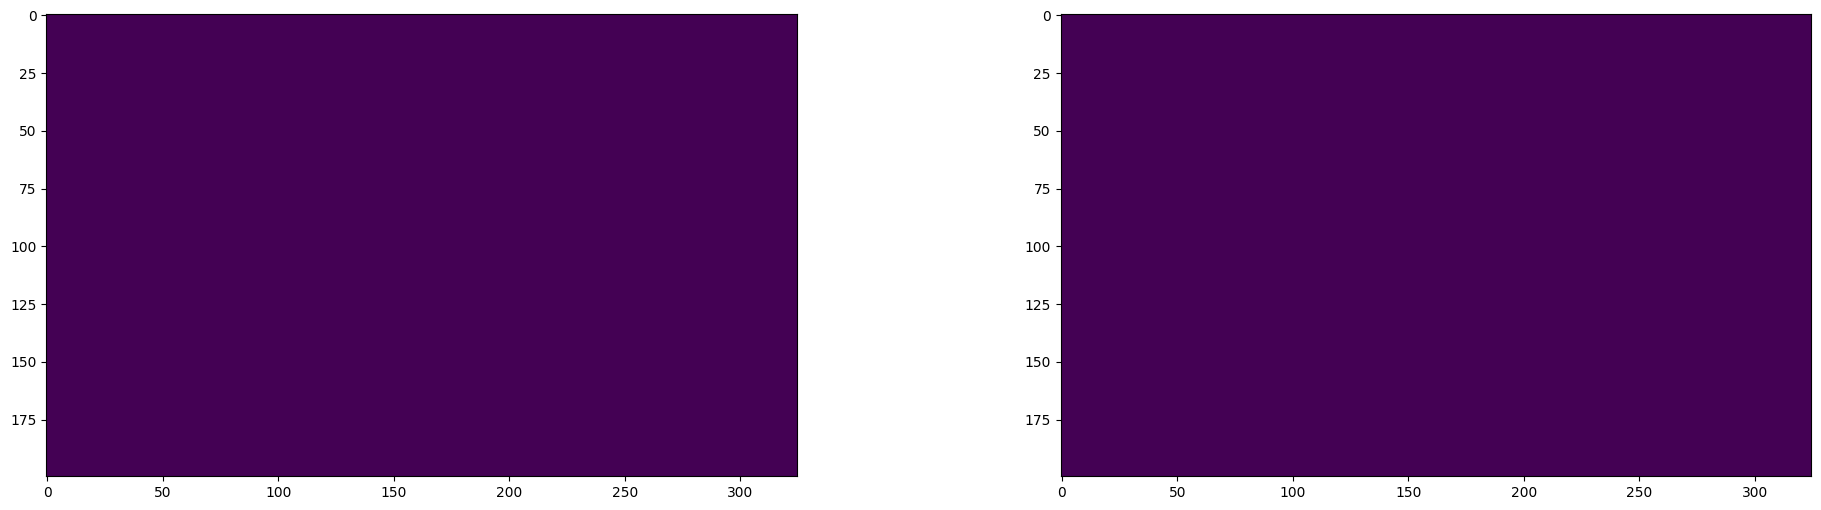

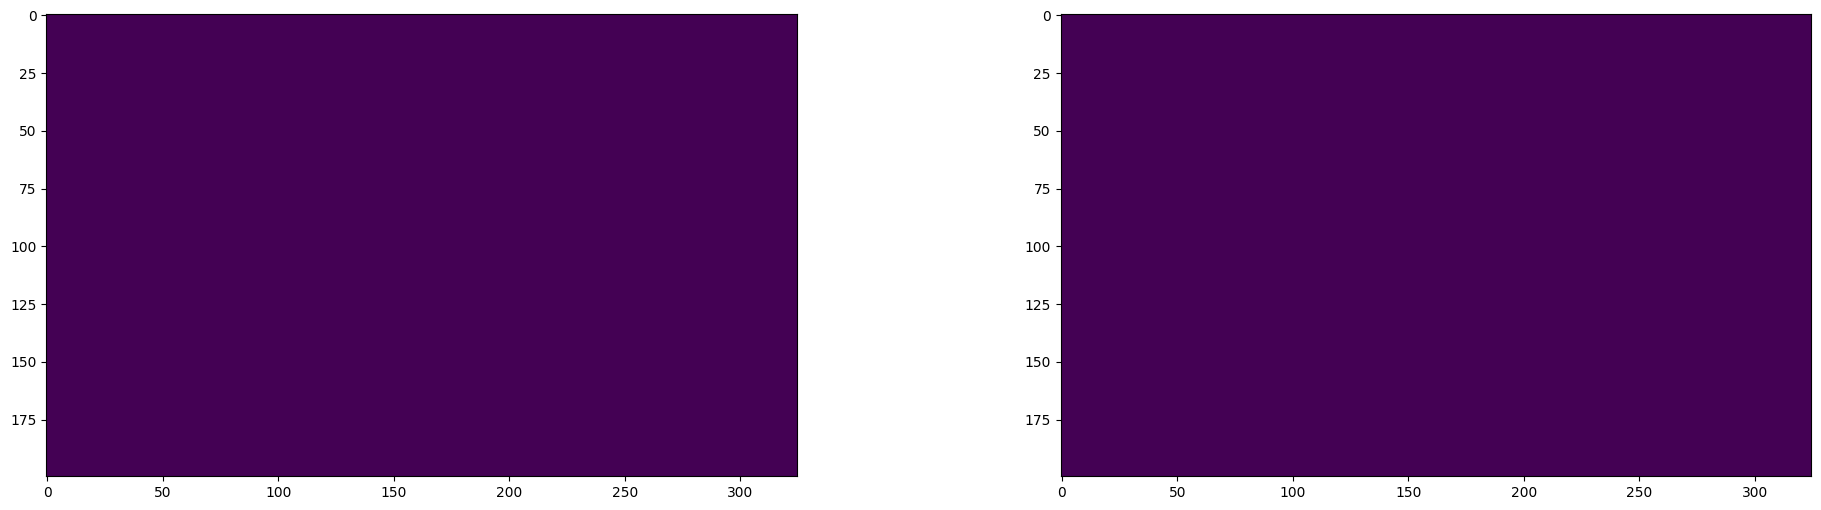

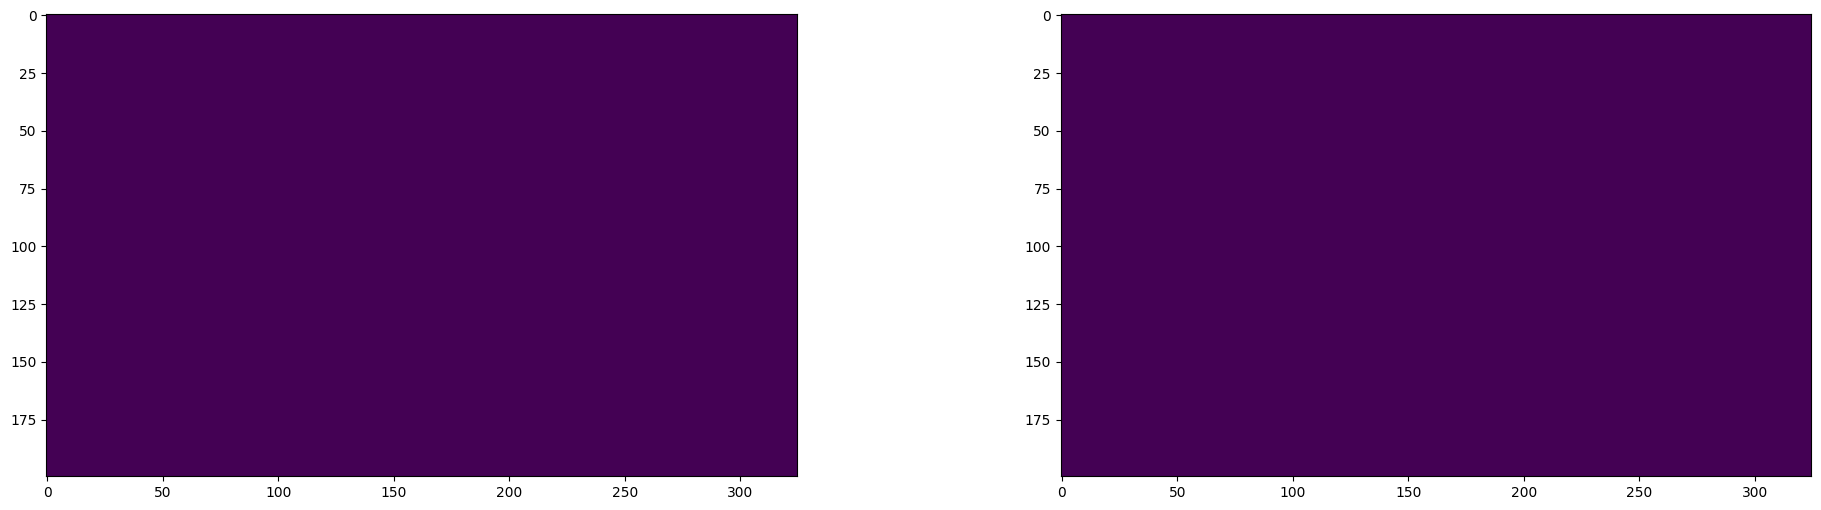

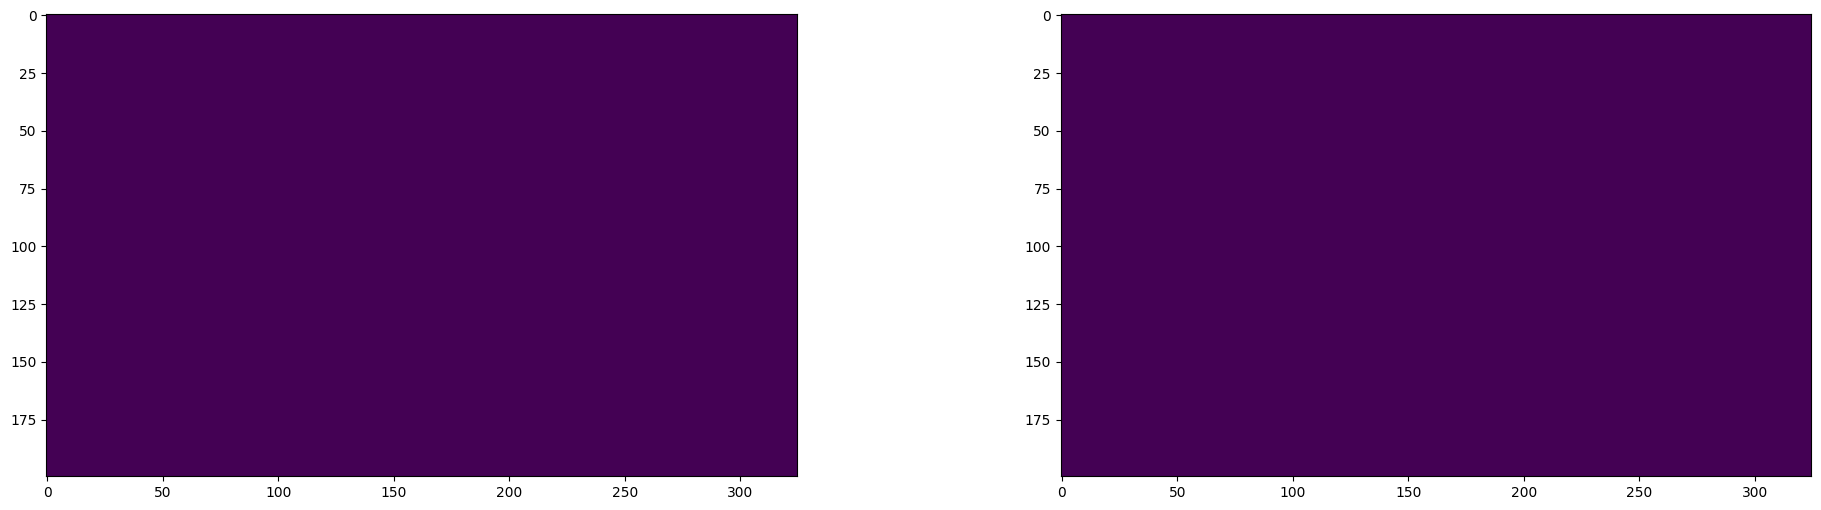

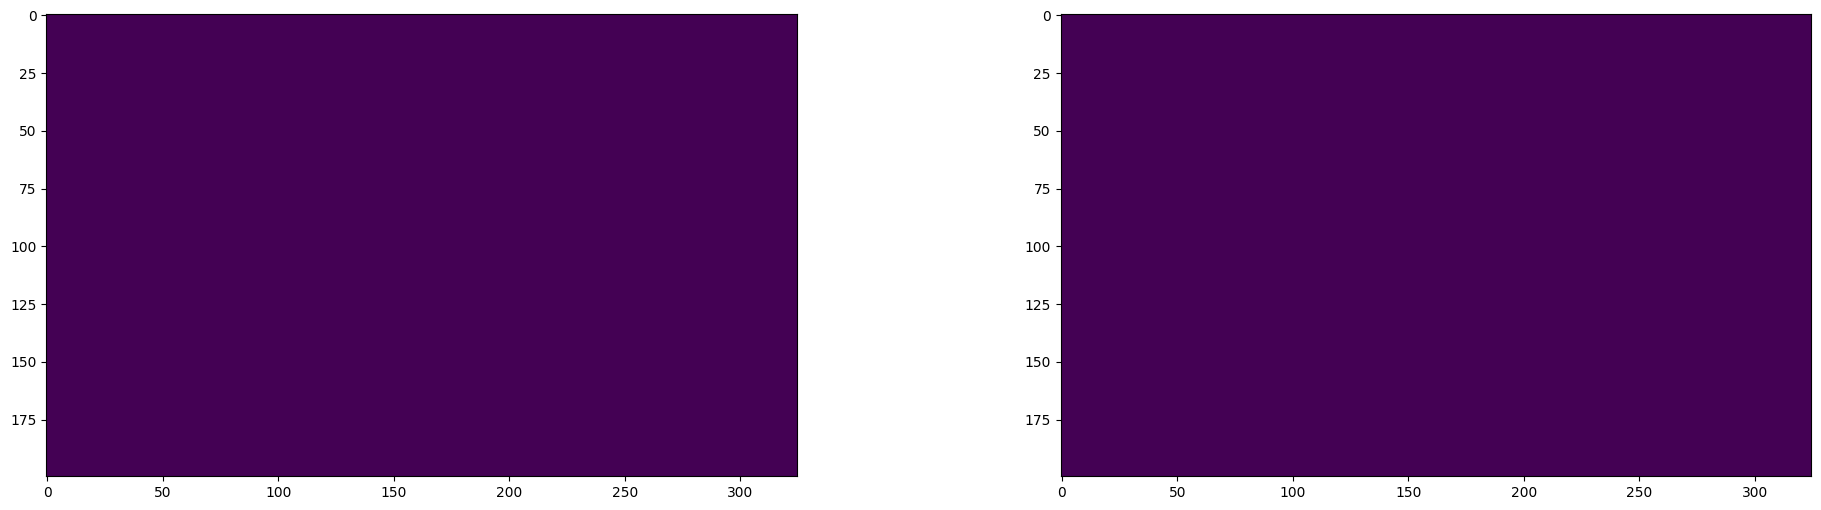

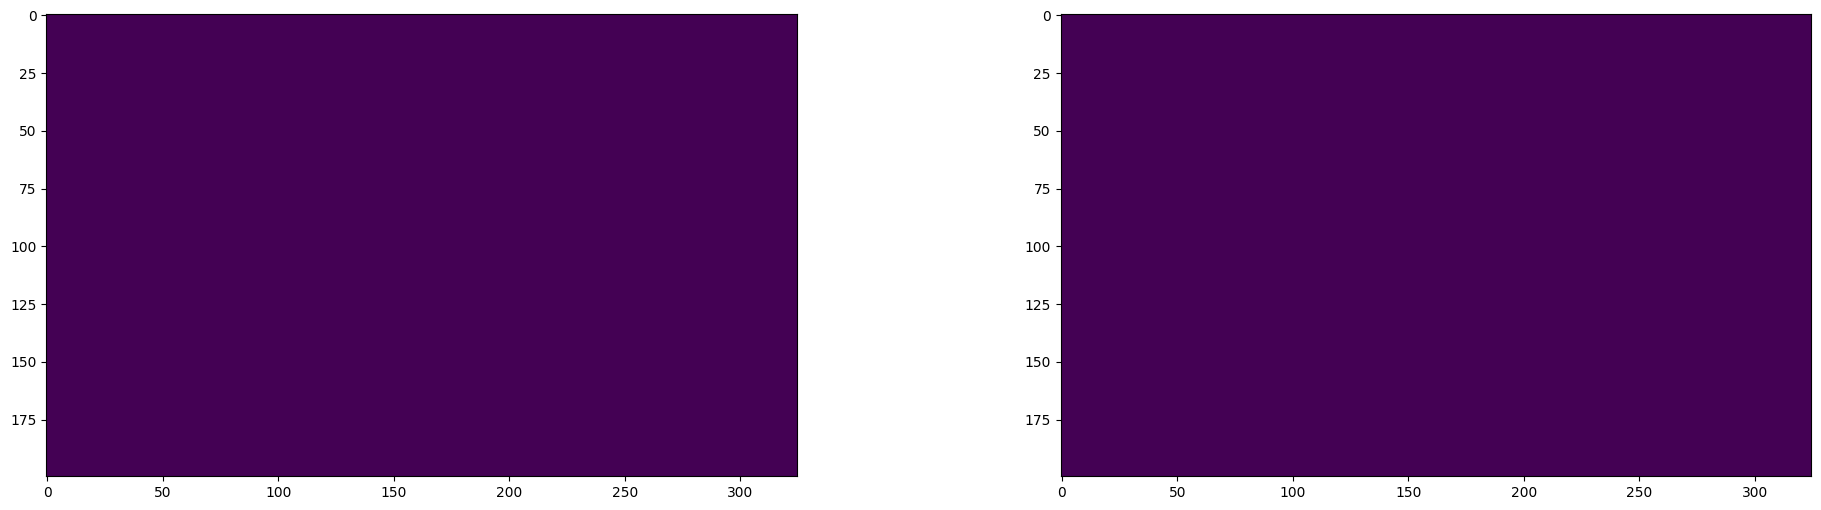

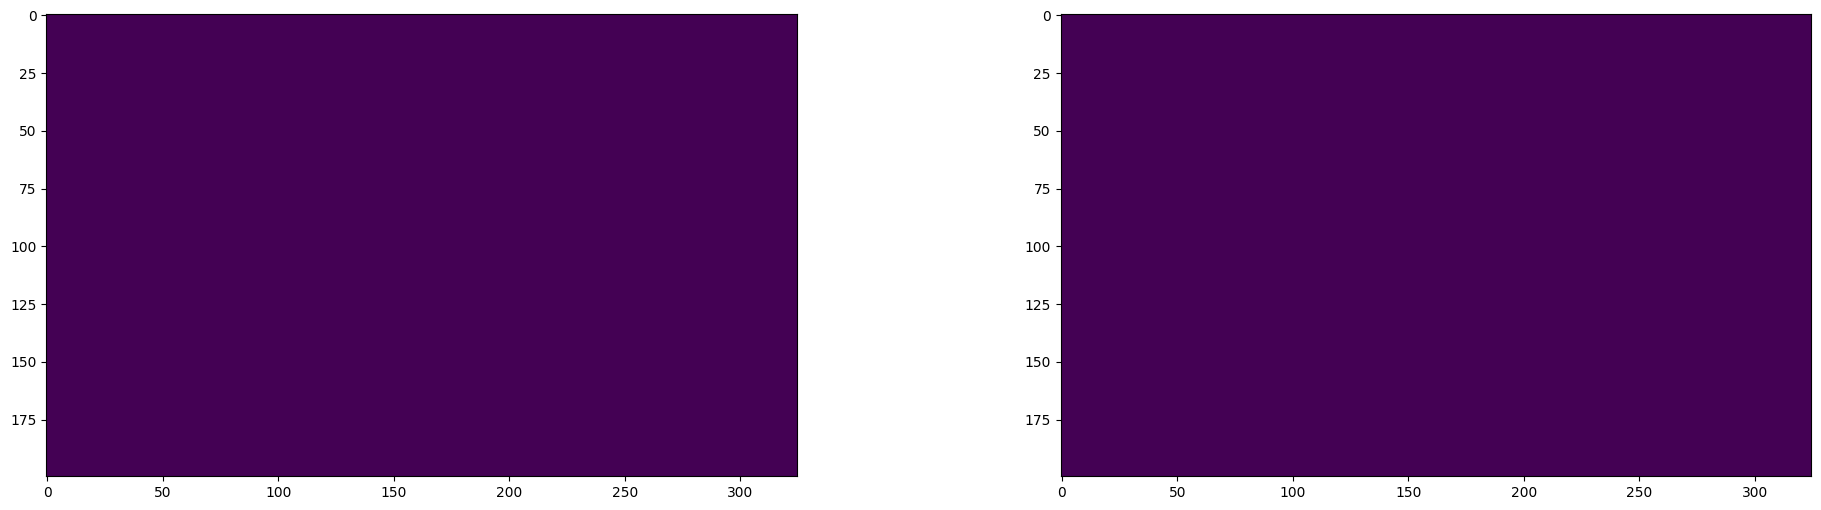

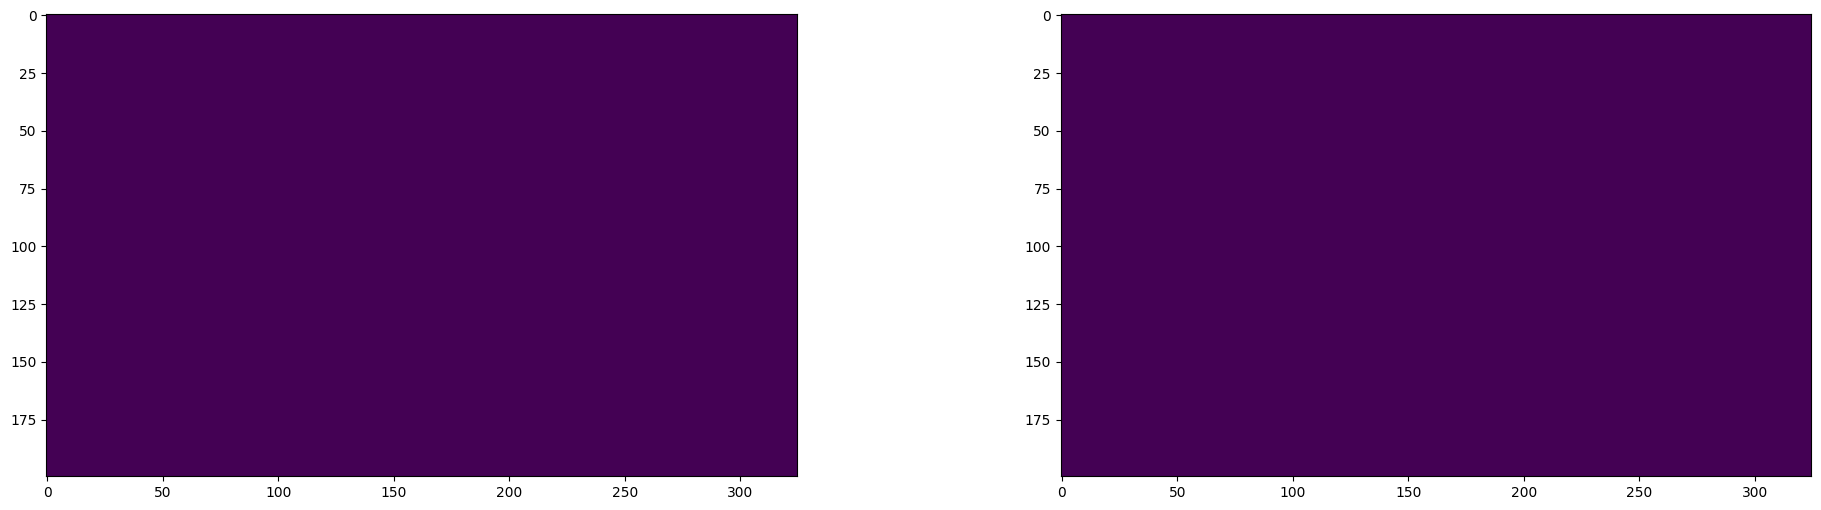

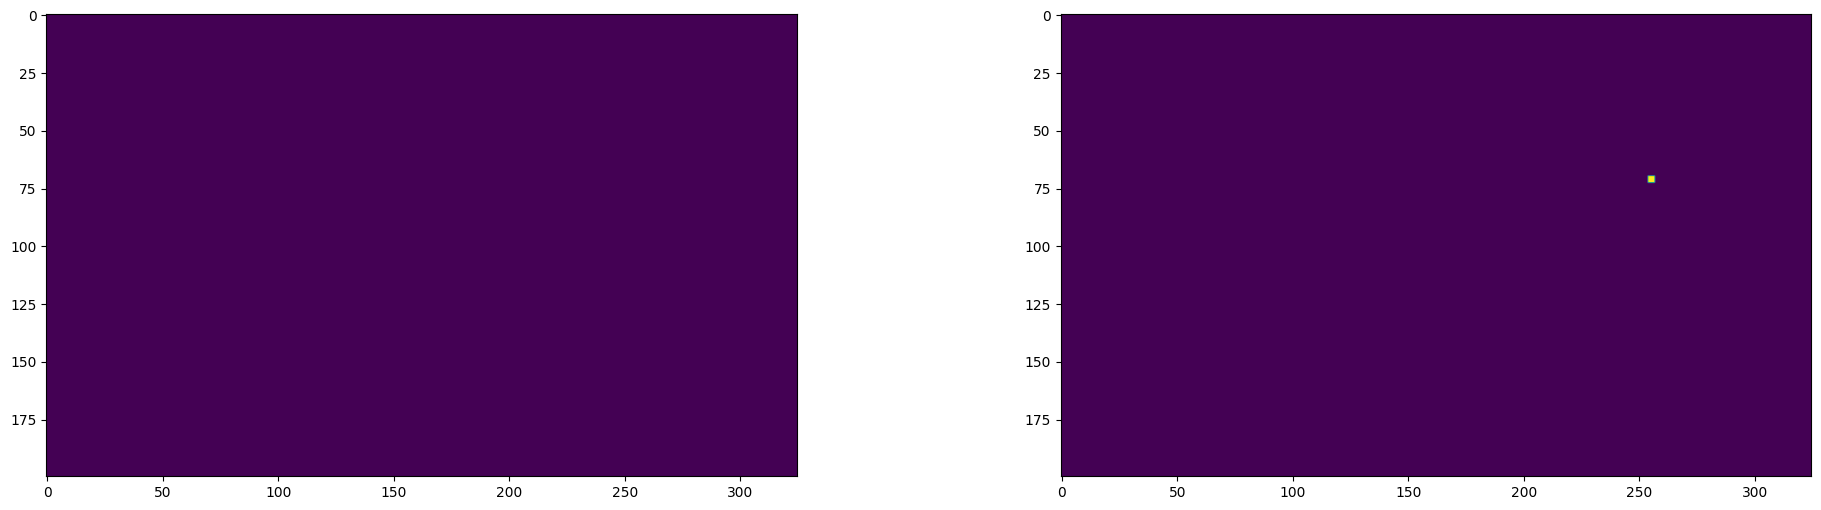

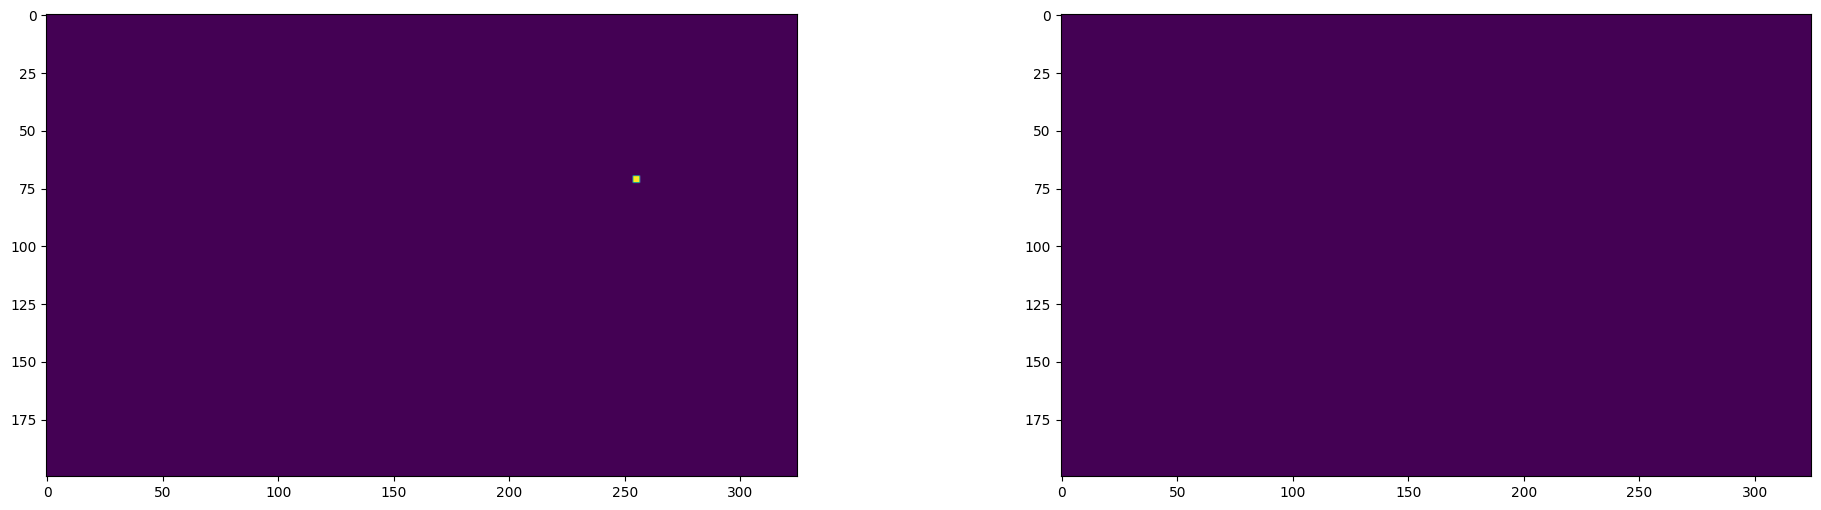

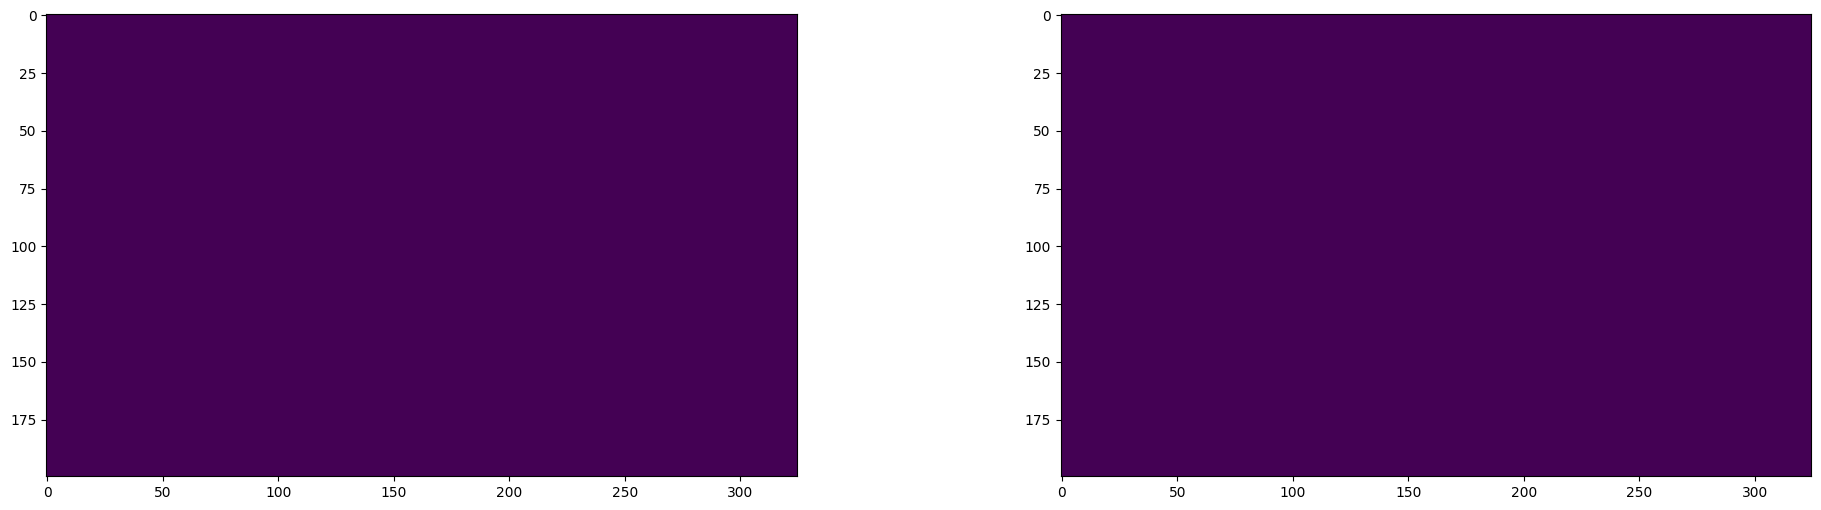

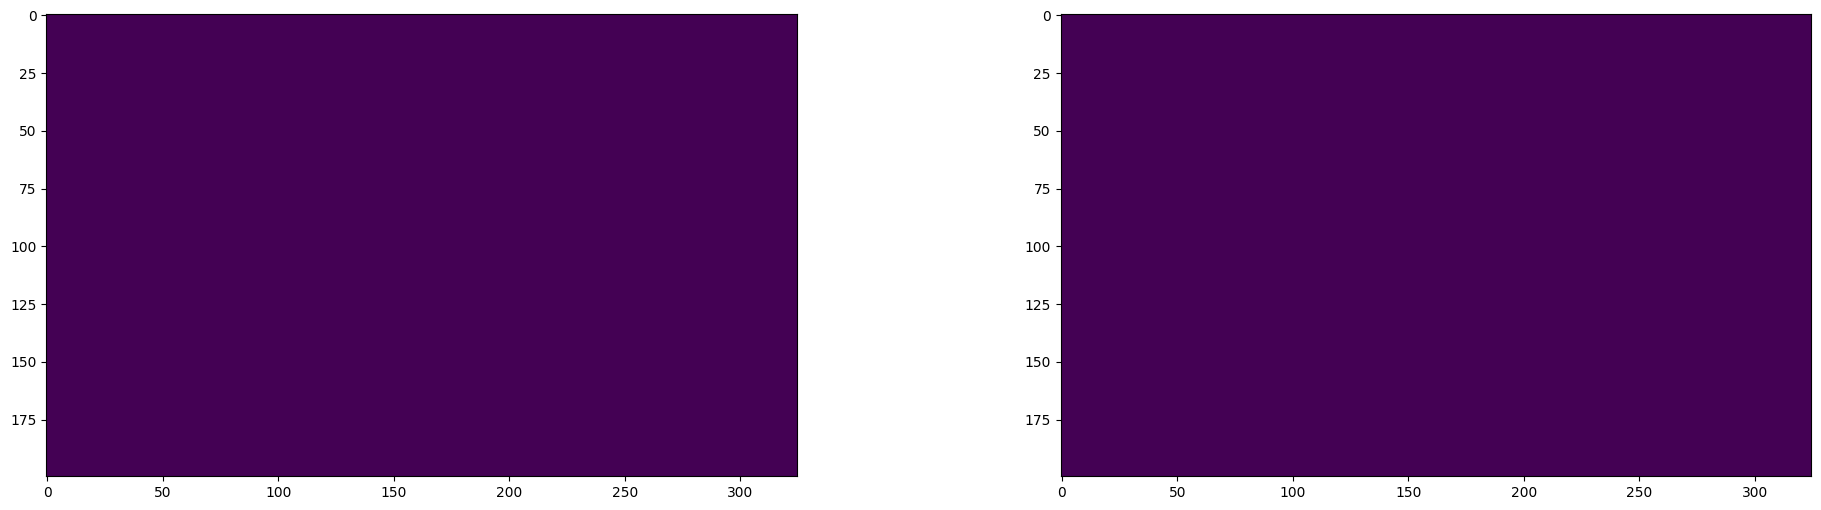

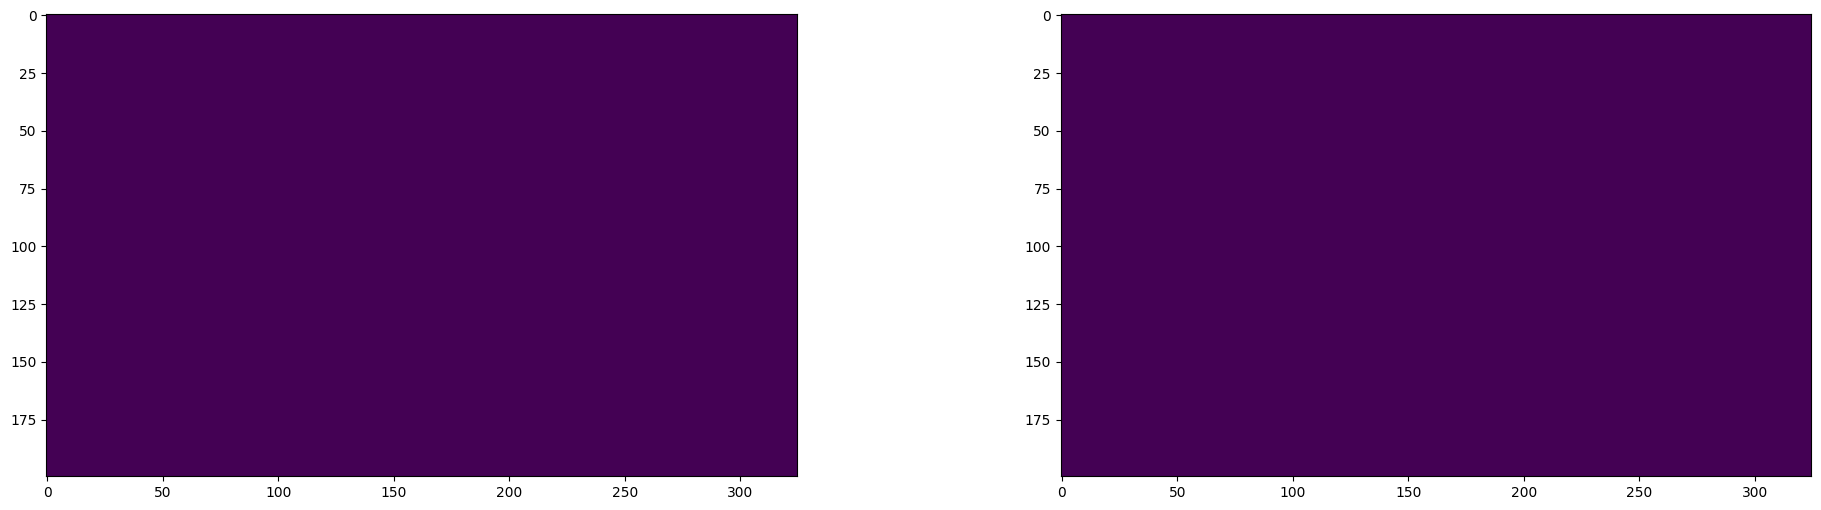

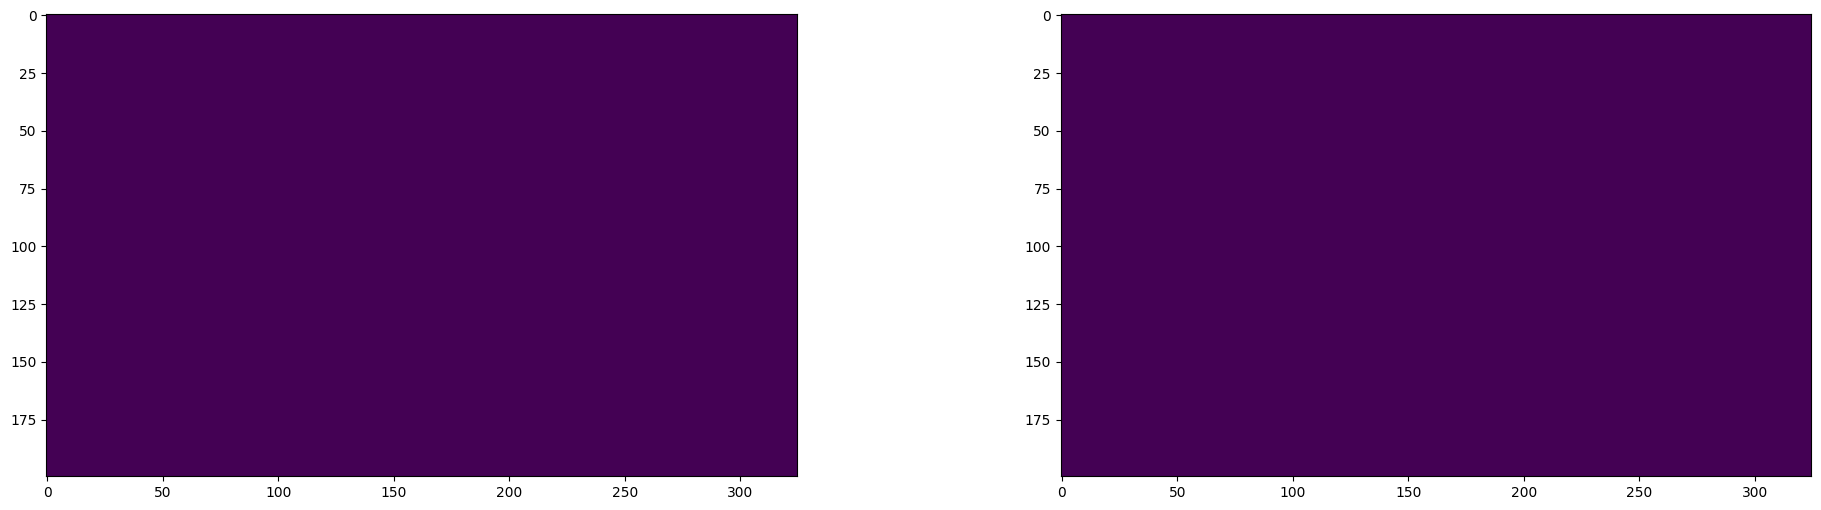

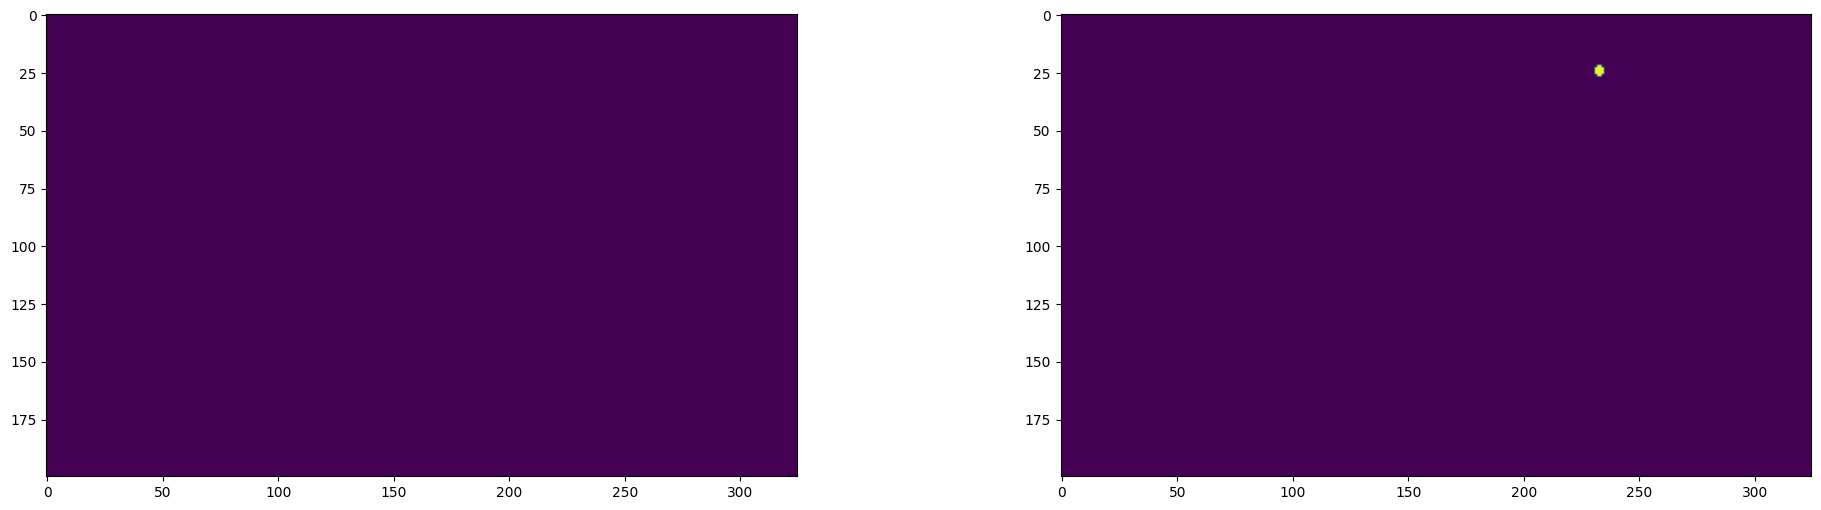

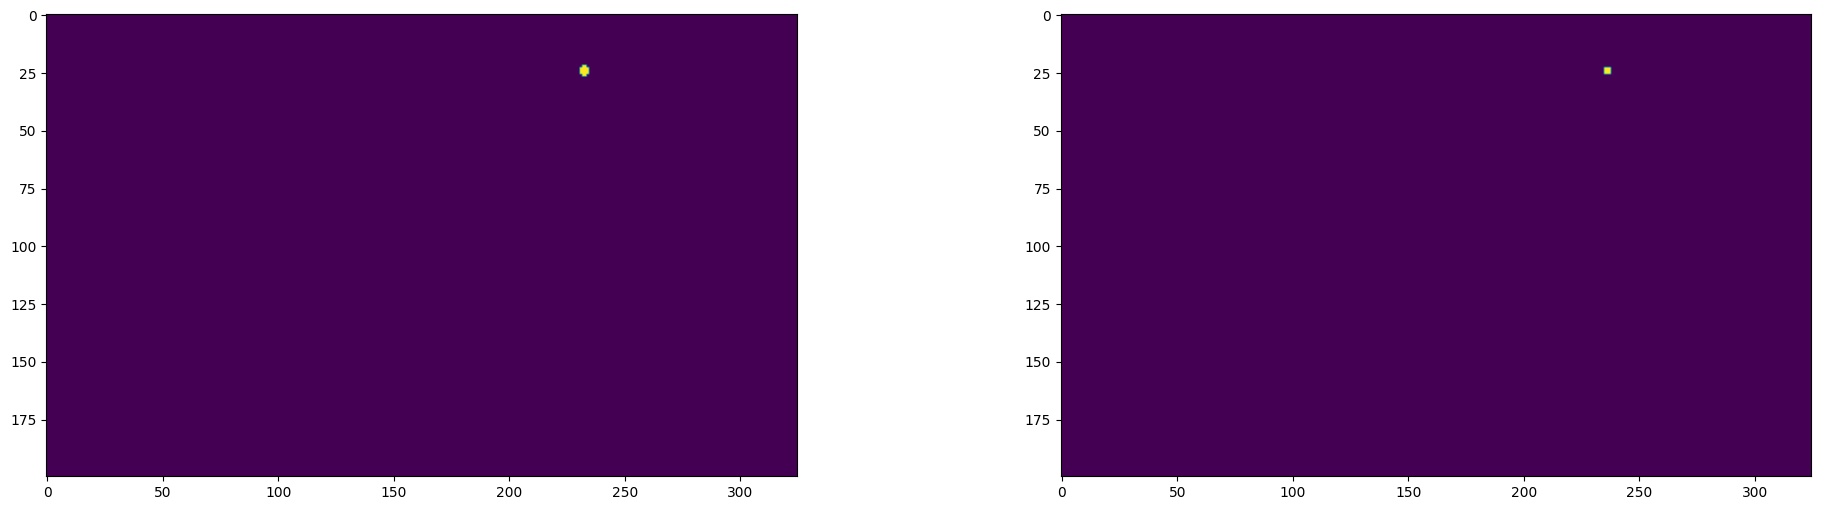

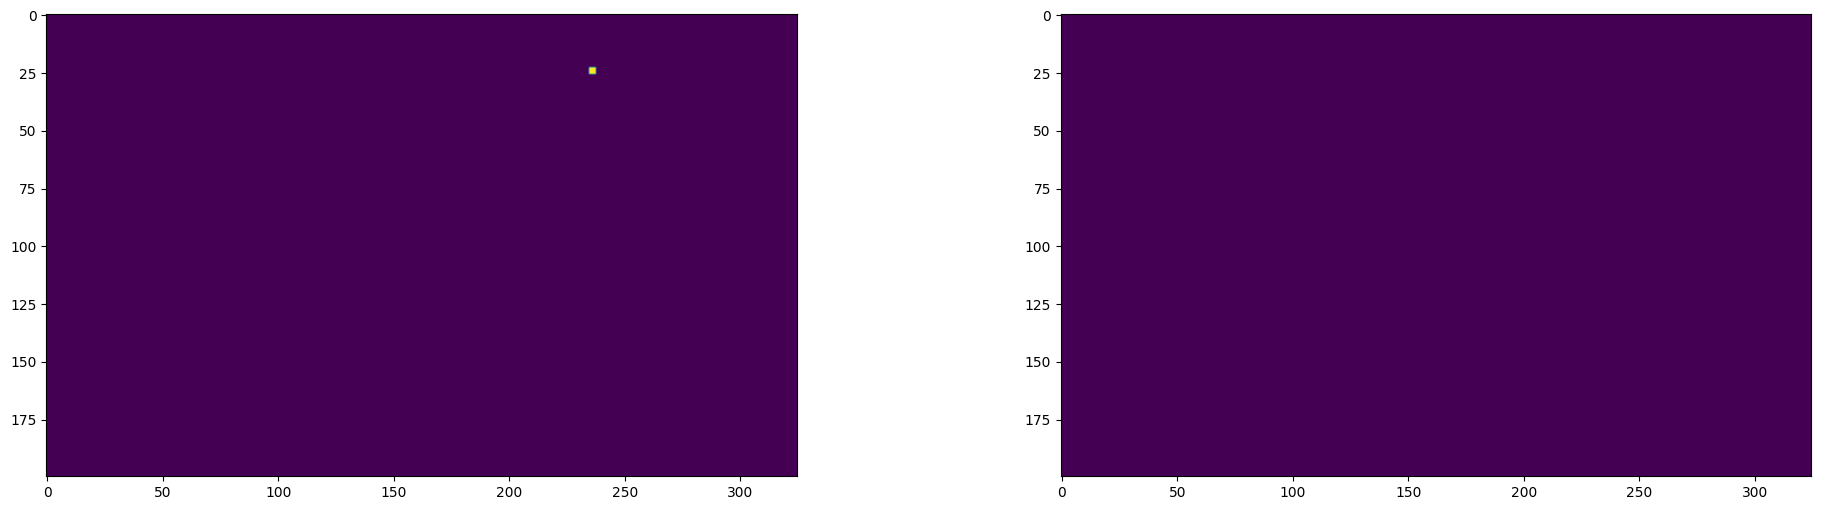

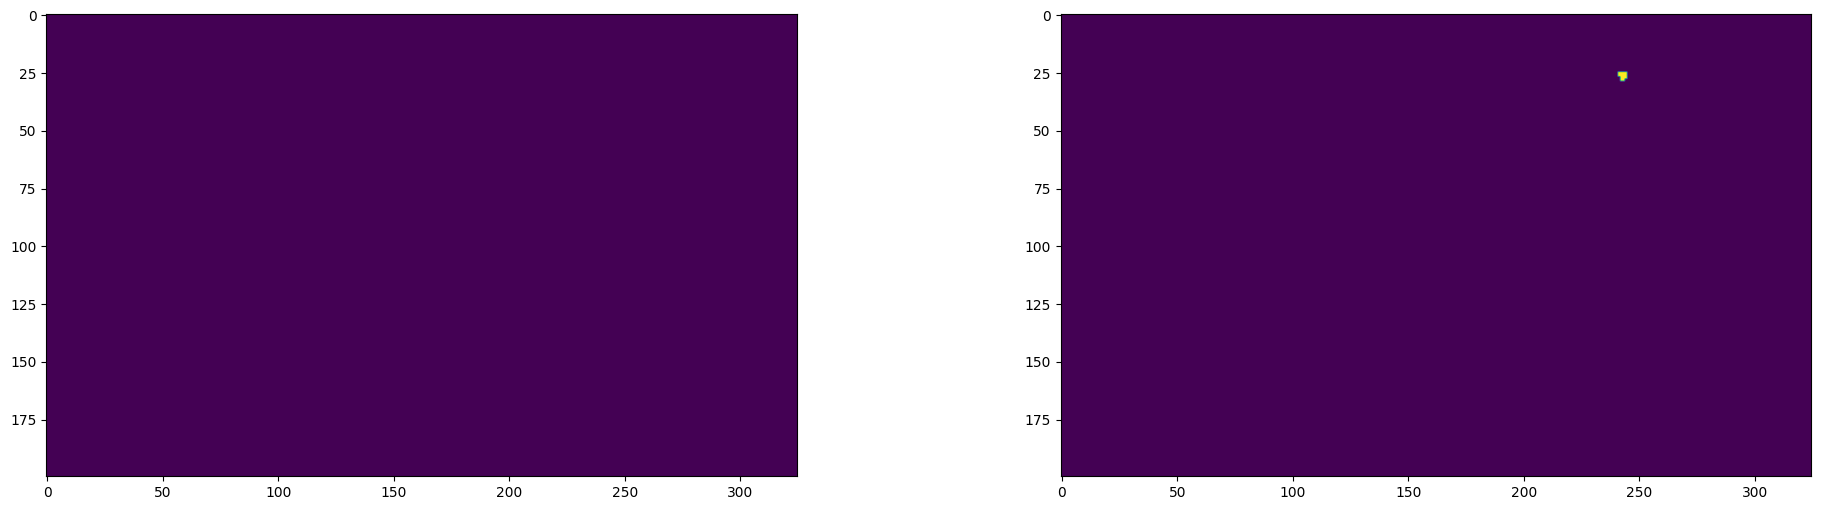

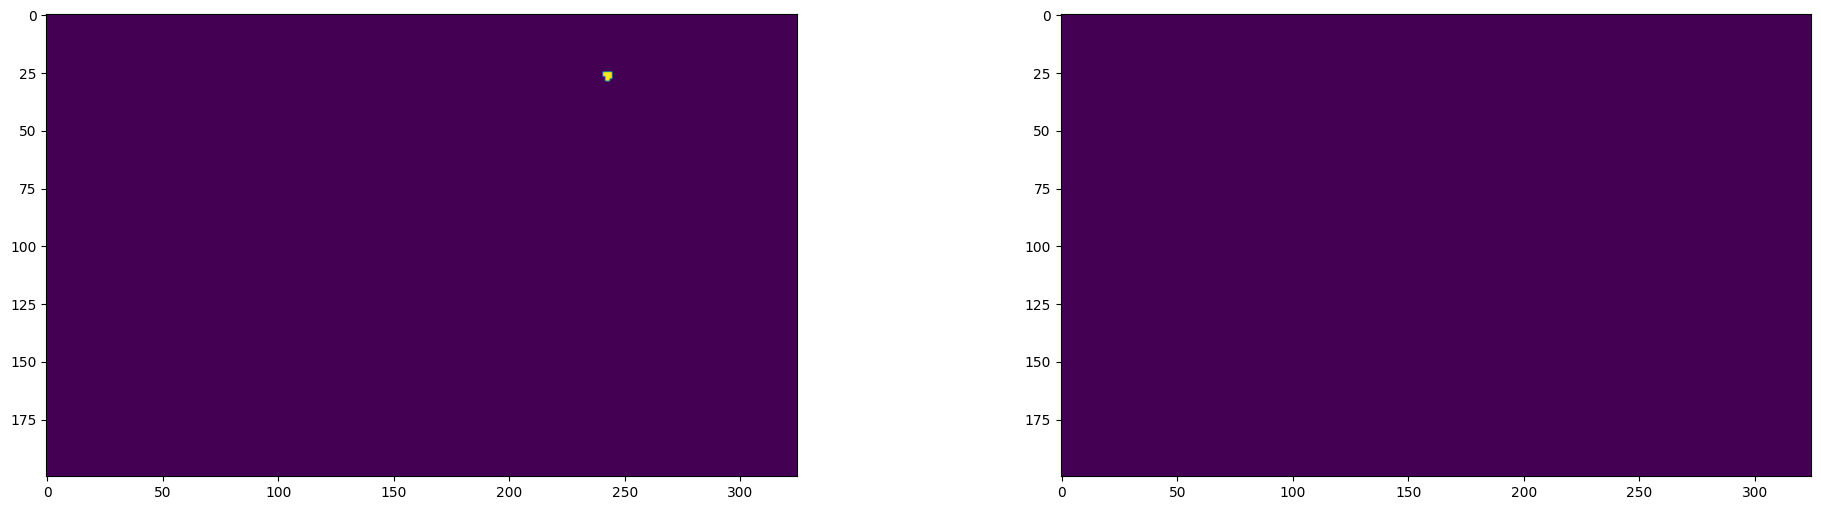

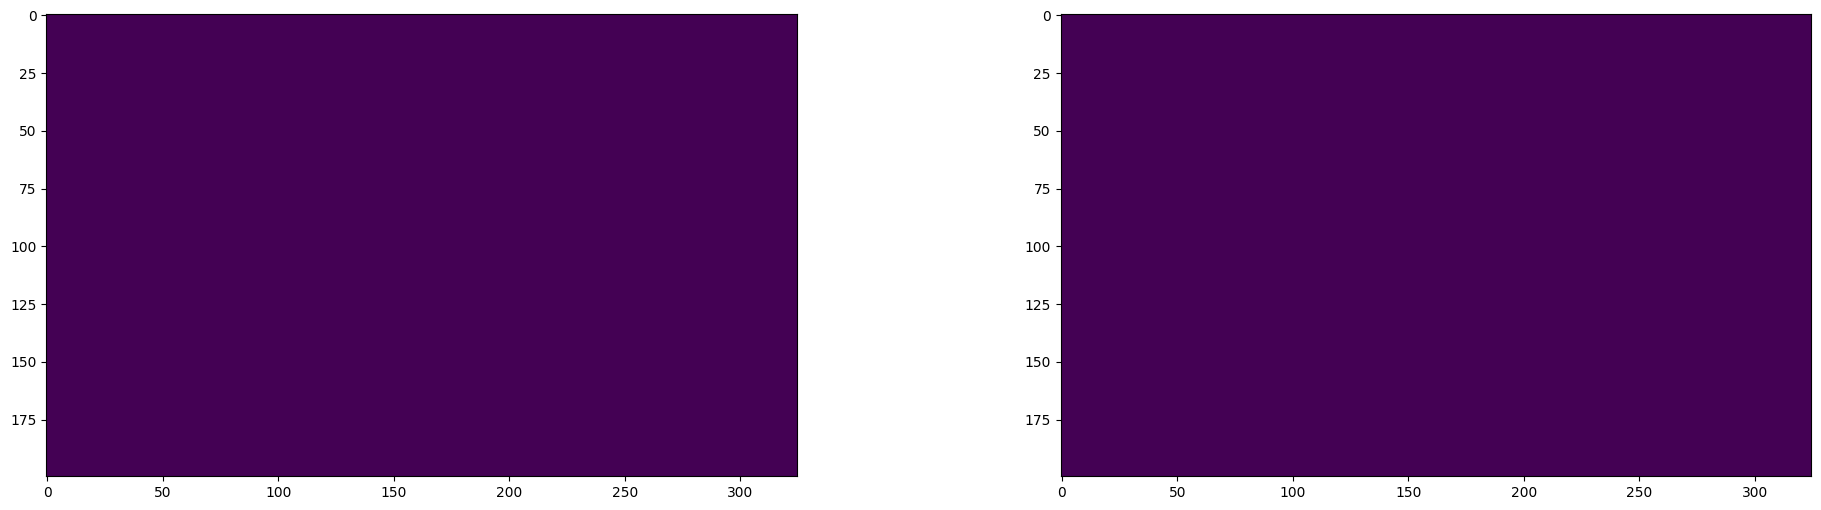

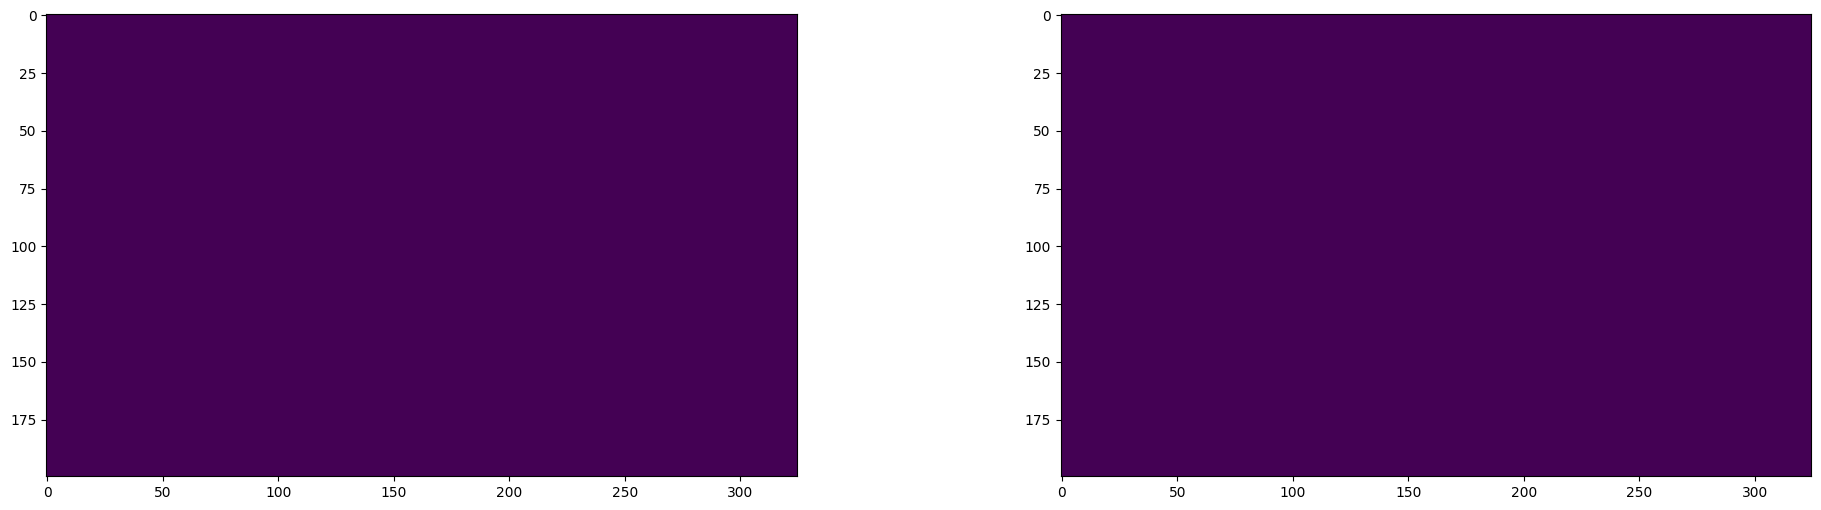

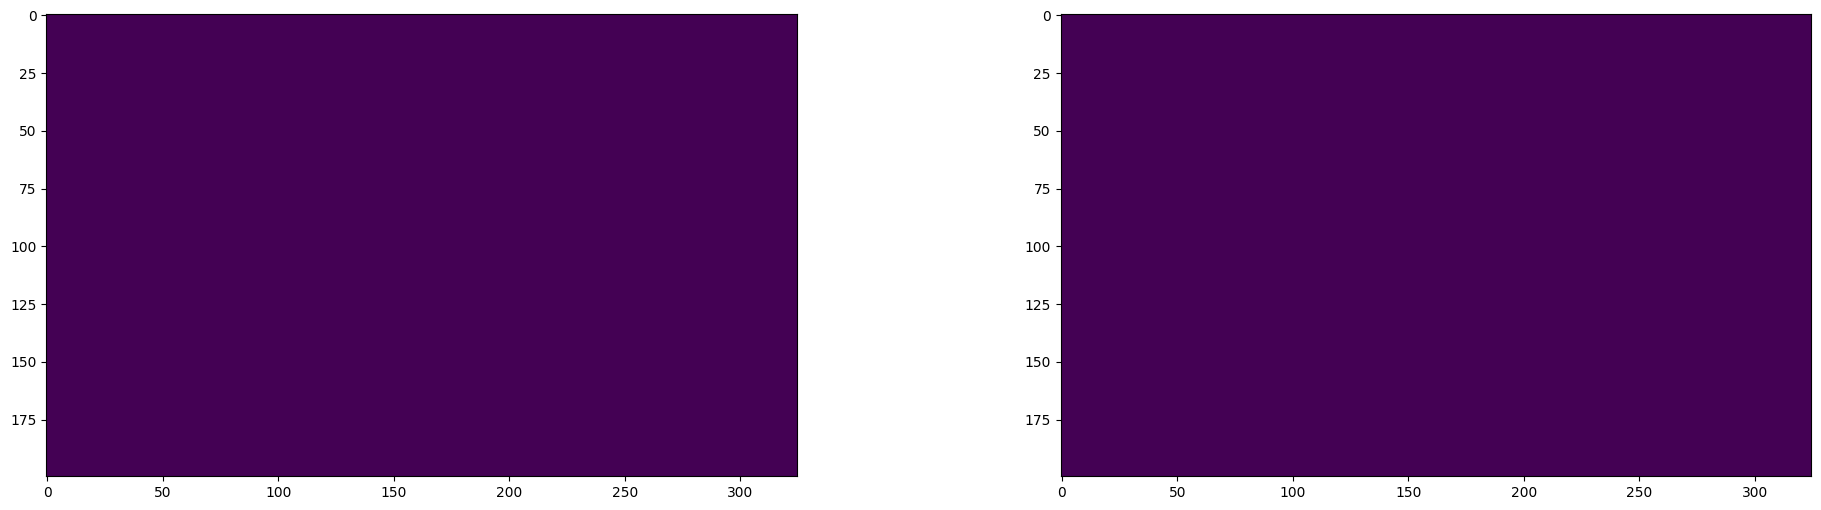

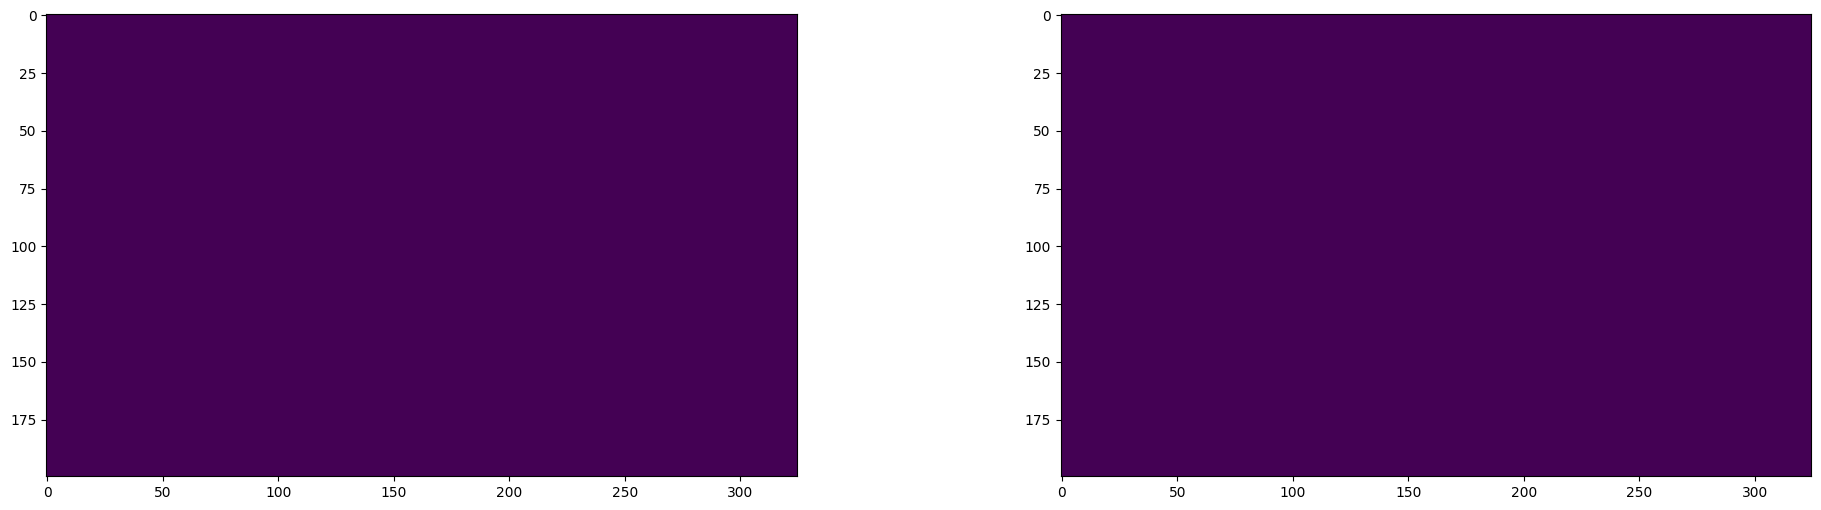

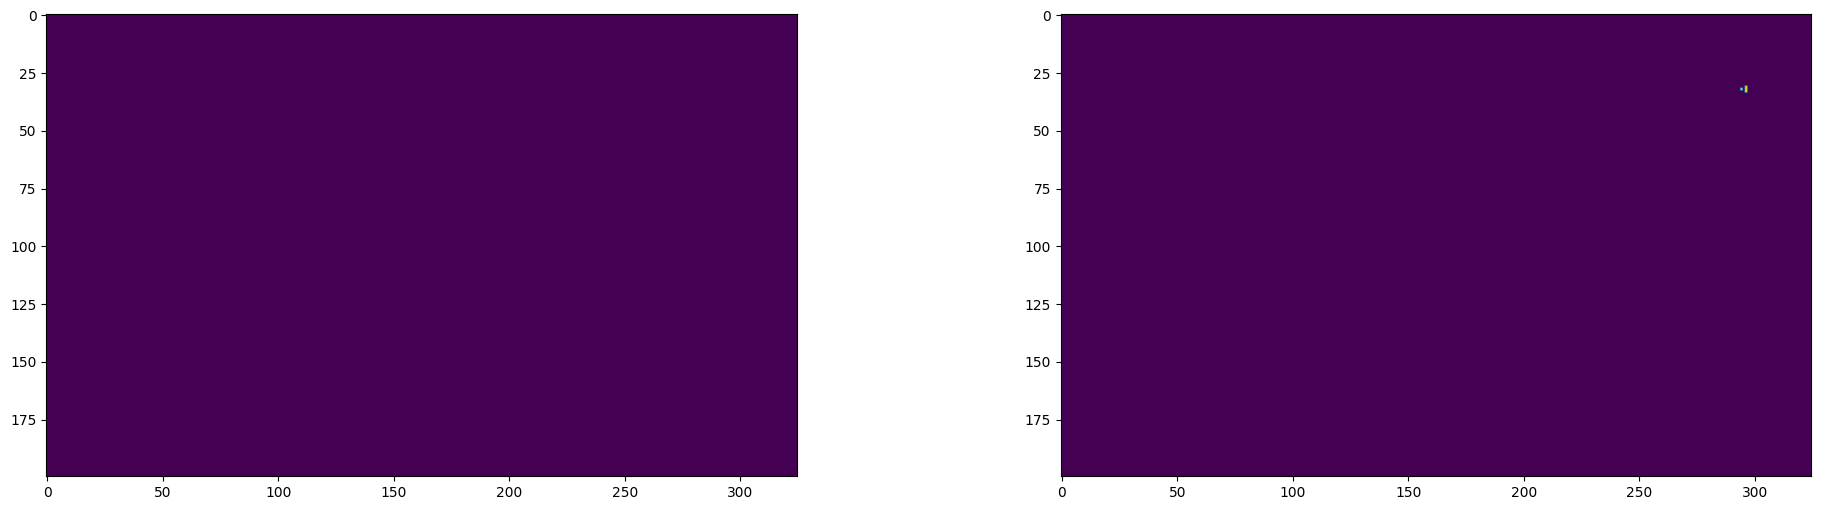

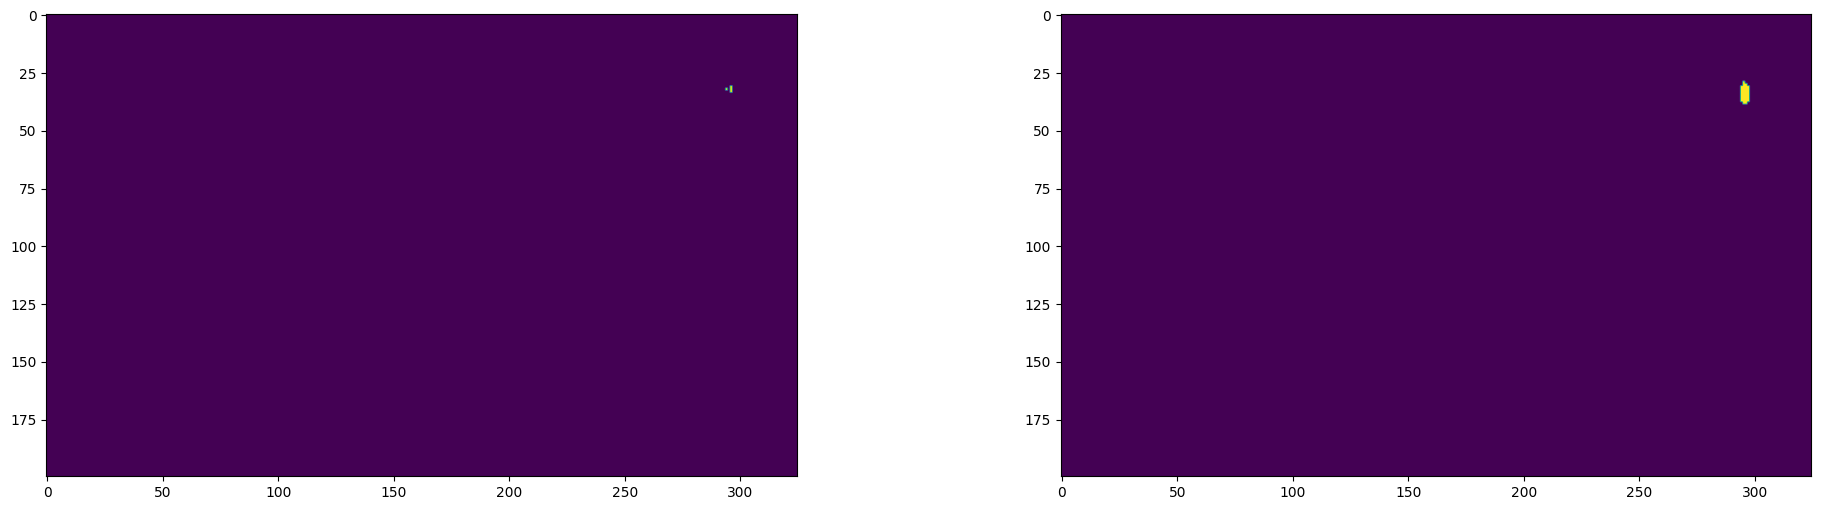

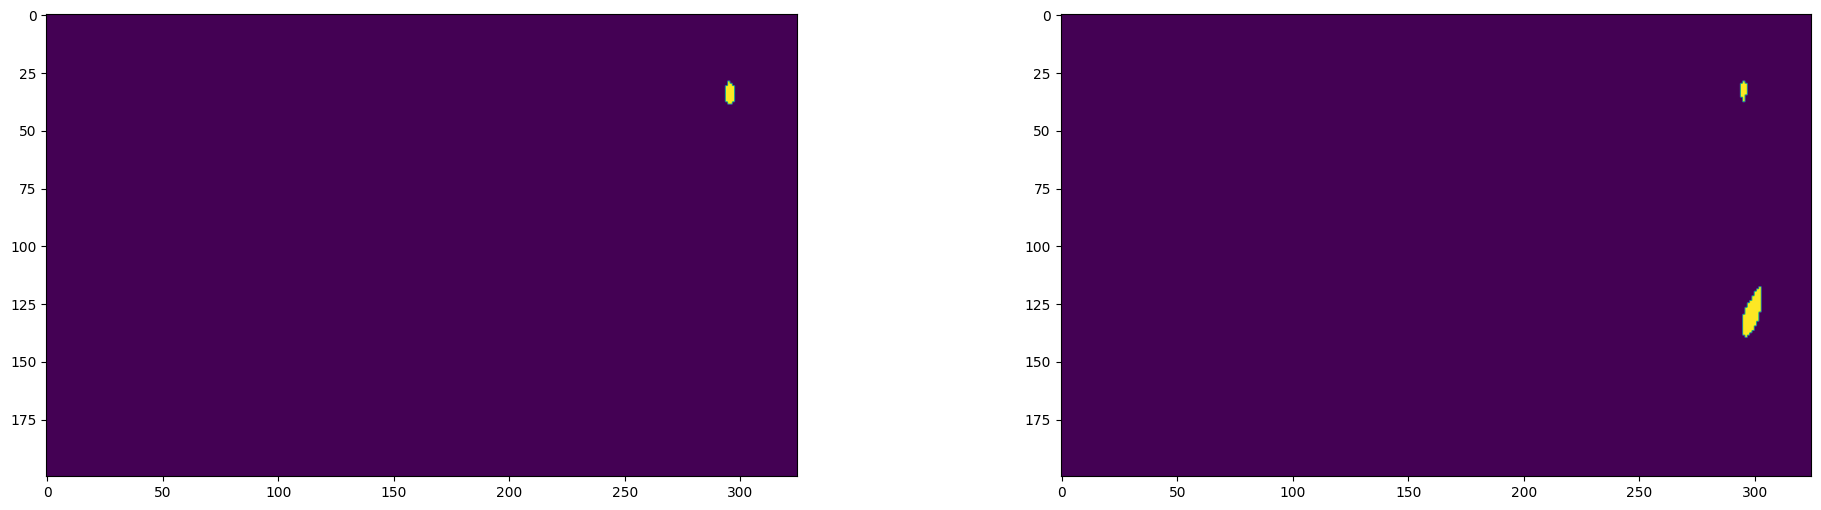

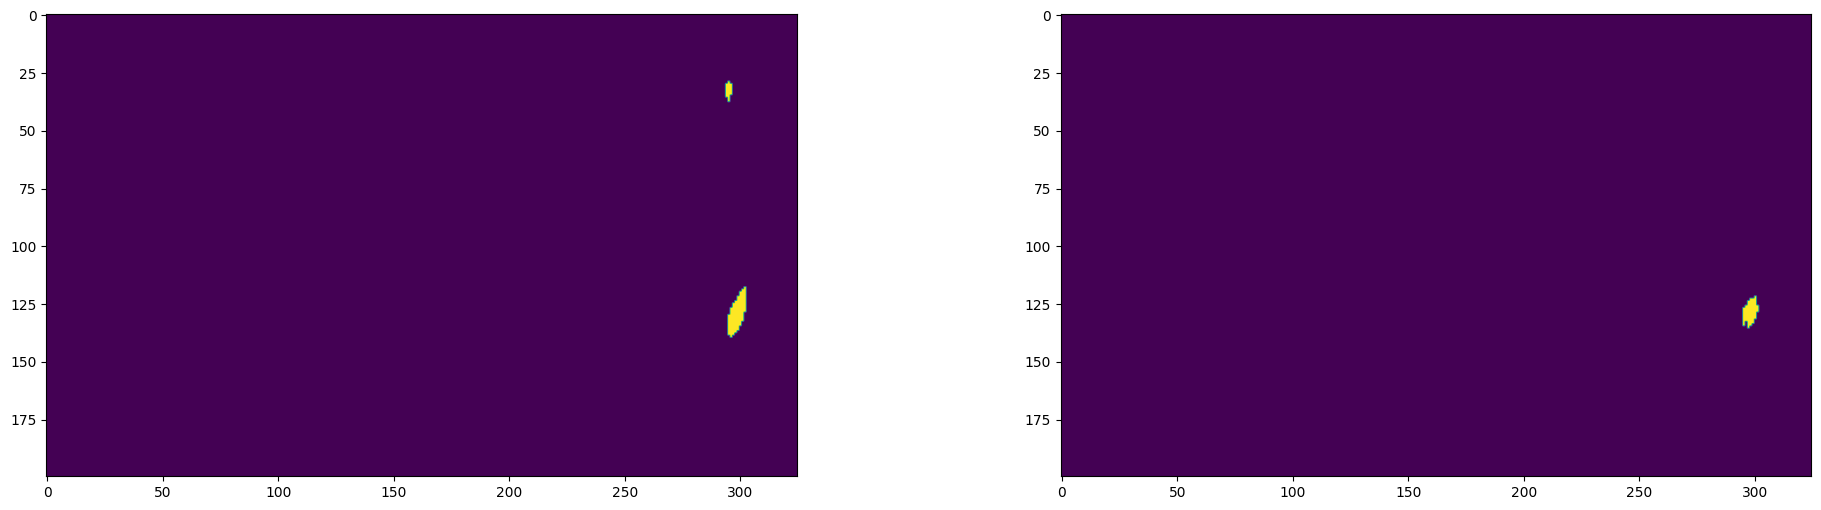

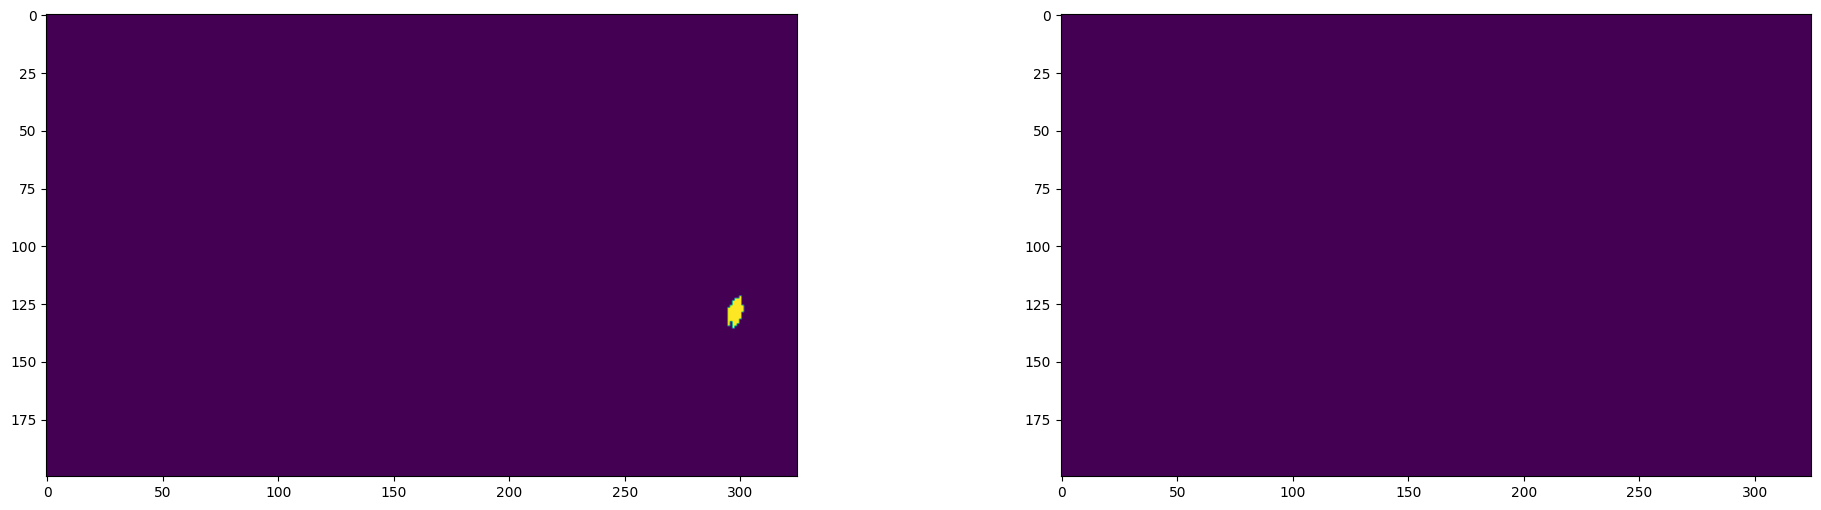

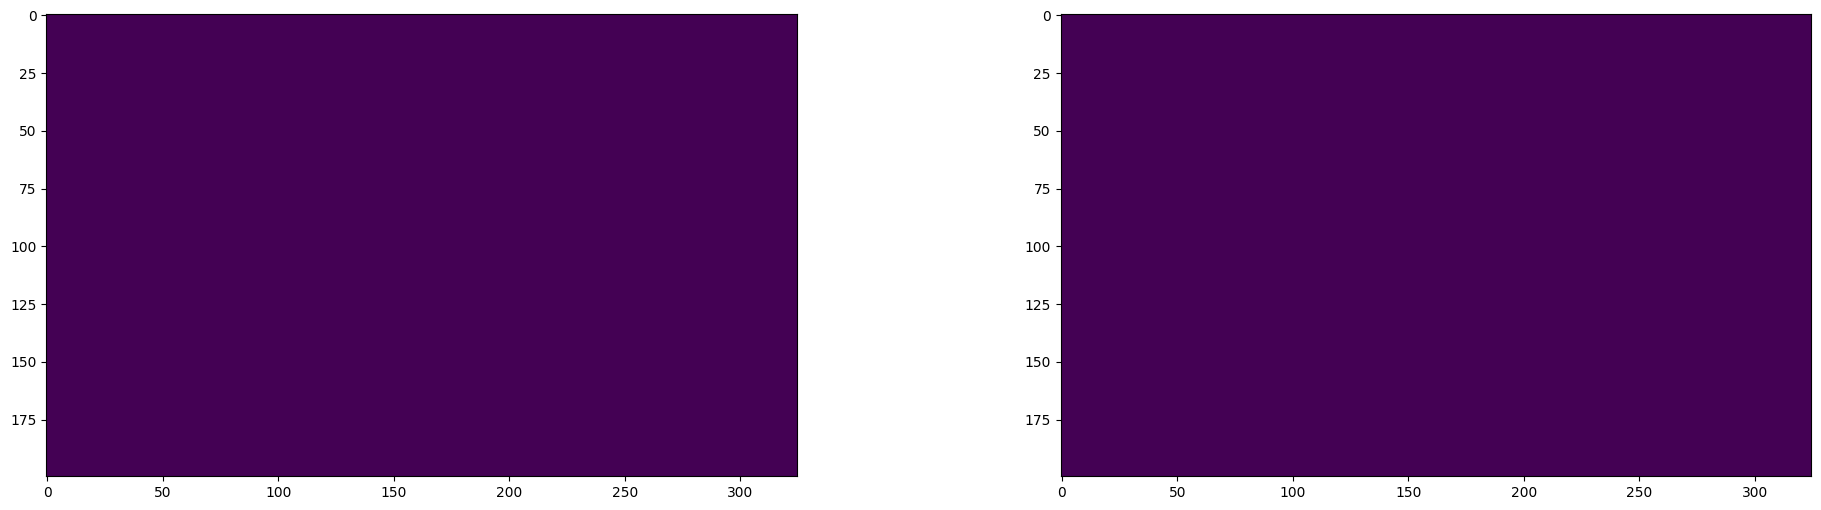

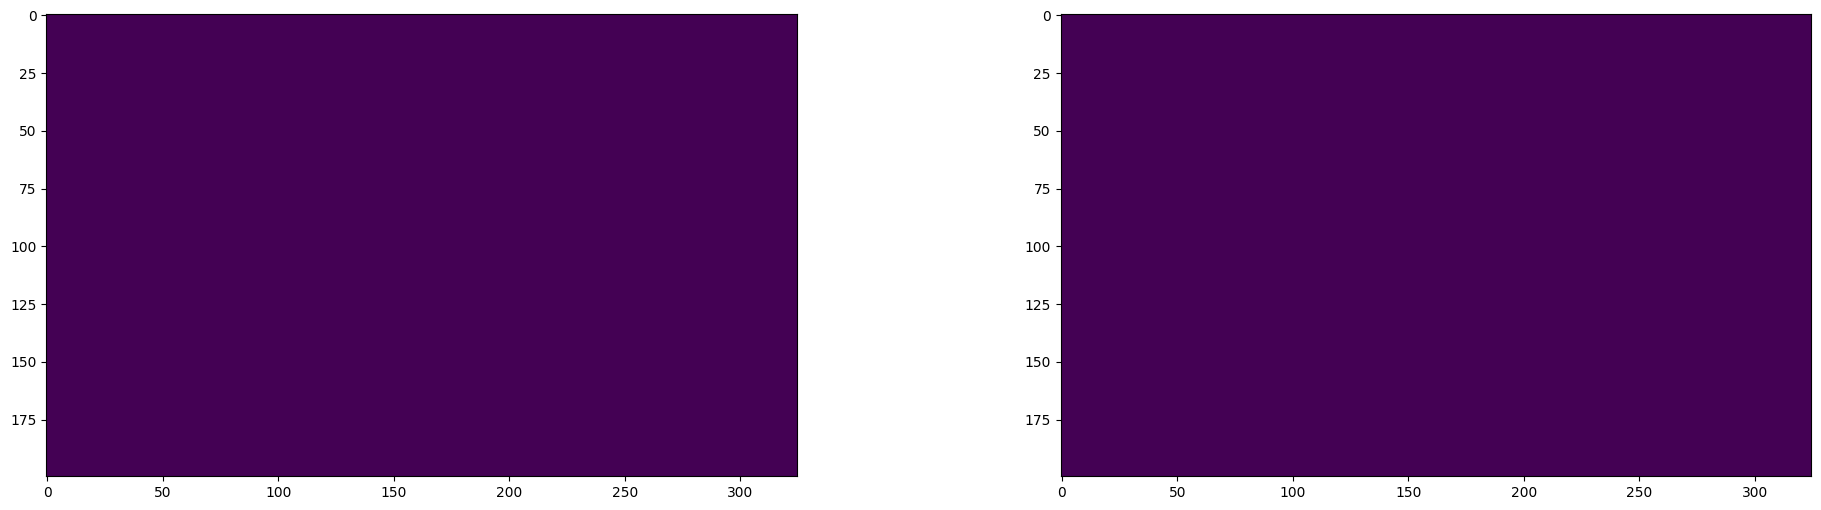

In [95]:
label = cropped['label']
print(label[0].shape)
for iter in range(39):
    plt.figure(figsize=(24,6))

    plt.subplot(1, 2, 1)
    plt.imshow(label[0][:, iter*5, :].detach().cpu())

    plt.subplot(1, 2, 2)
    plt.imshow(label[0][:, iter*5 + 5, :].detach().cpu())

GT mask volumne tensor(1299.)
torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])
cropped GT volumne: tensor(857.)


/tmp/ipykernel_588847/3566338973.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(24,6))


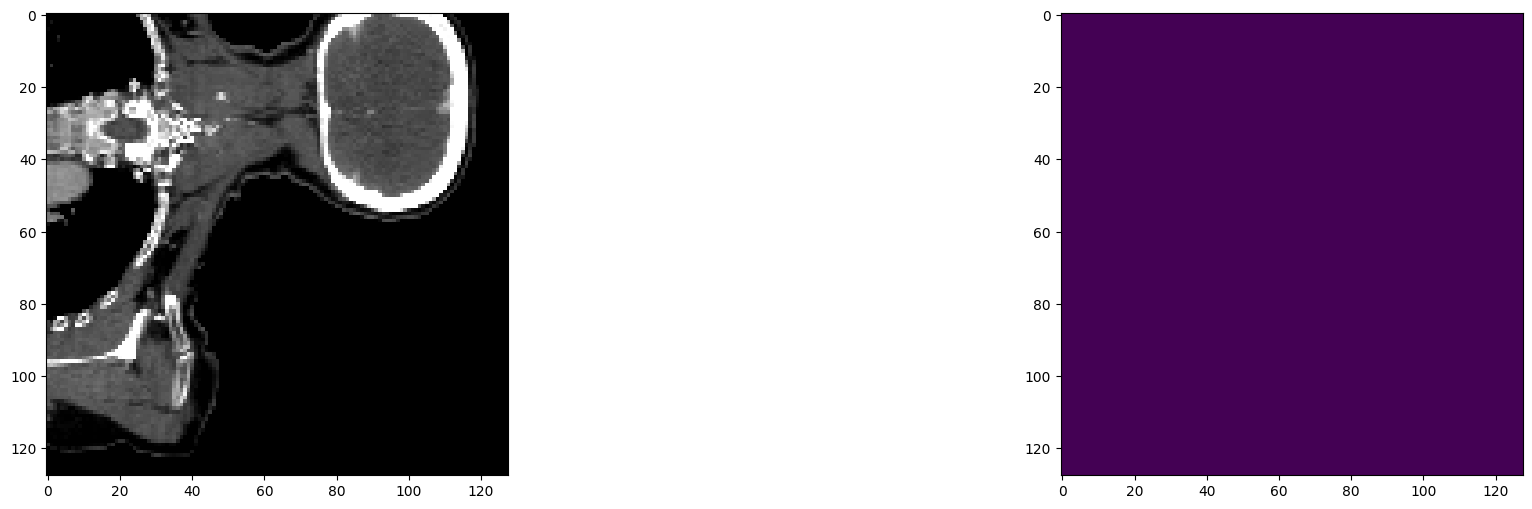

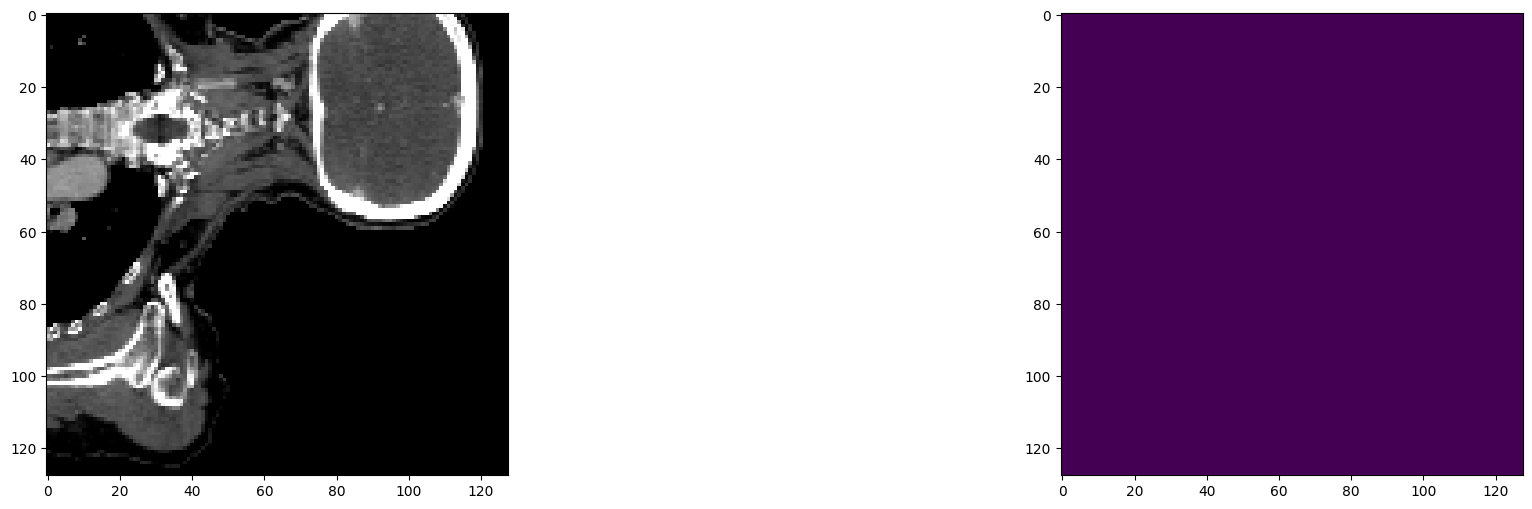

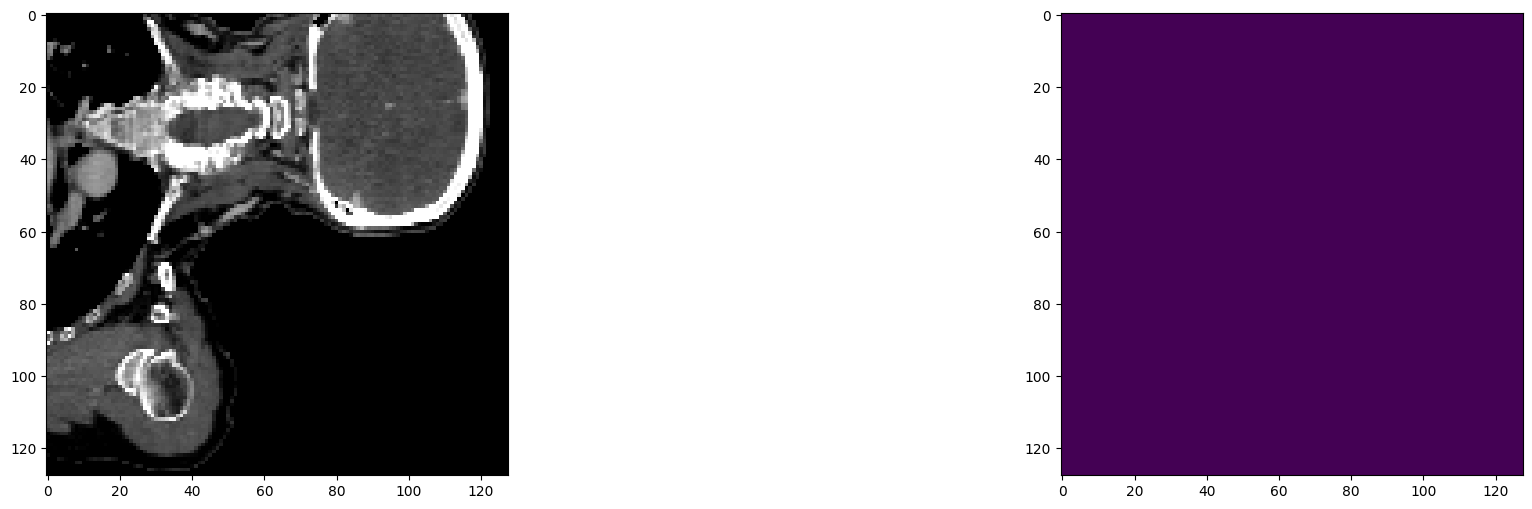

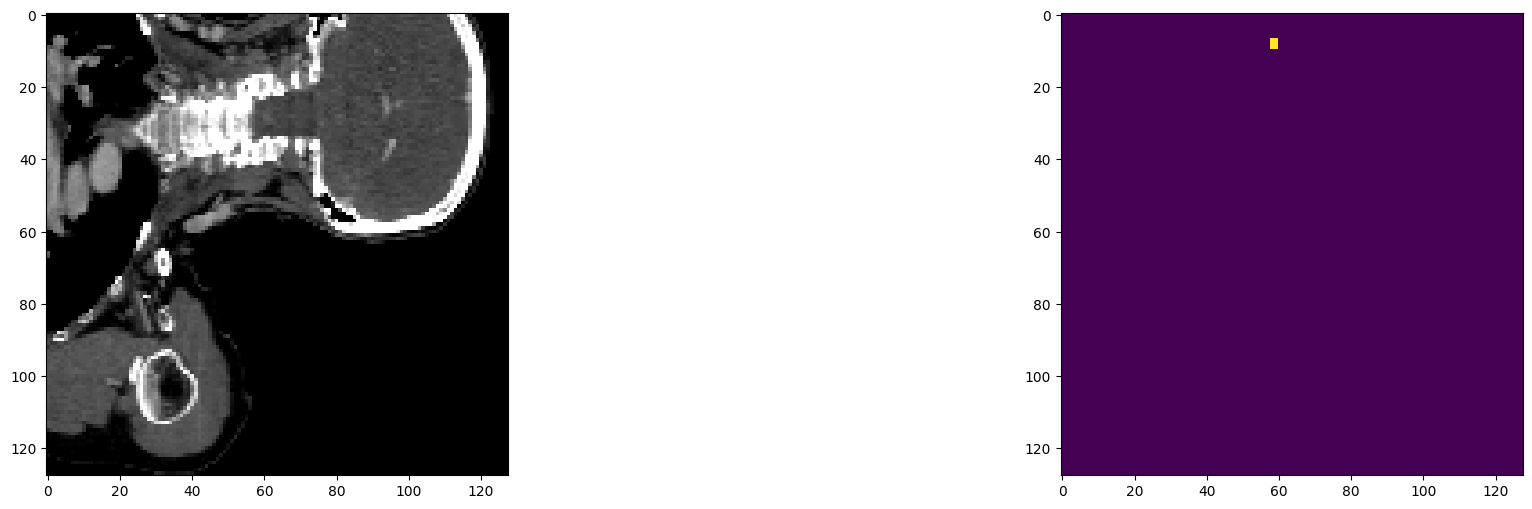

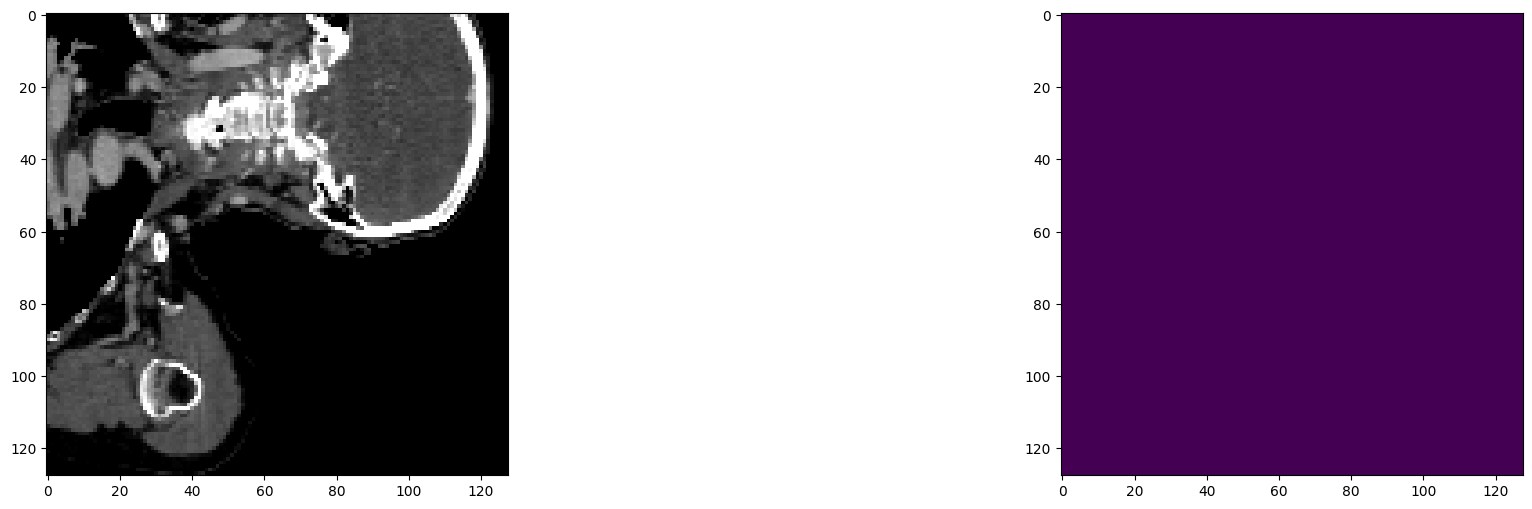

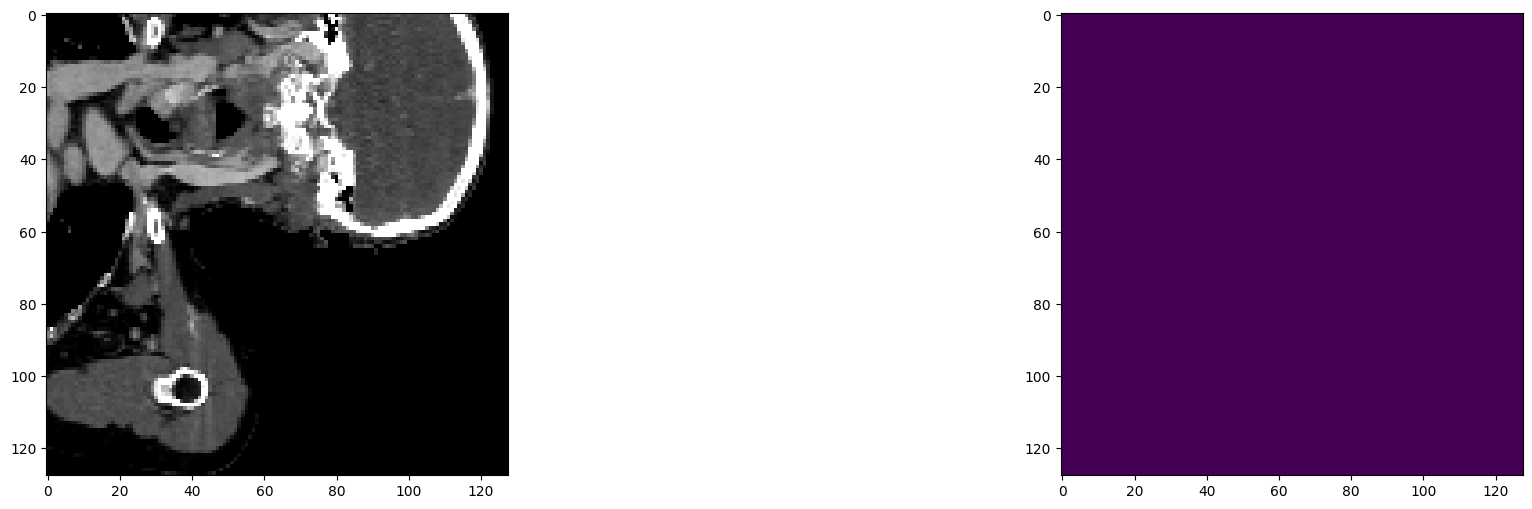

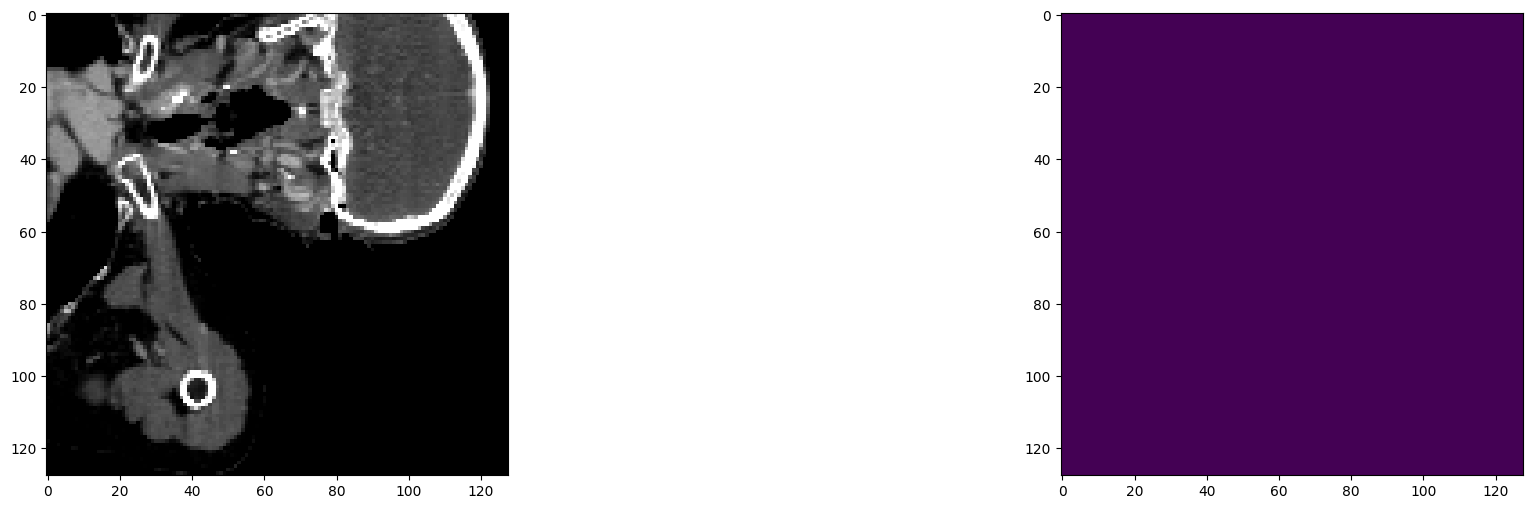

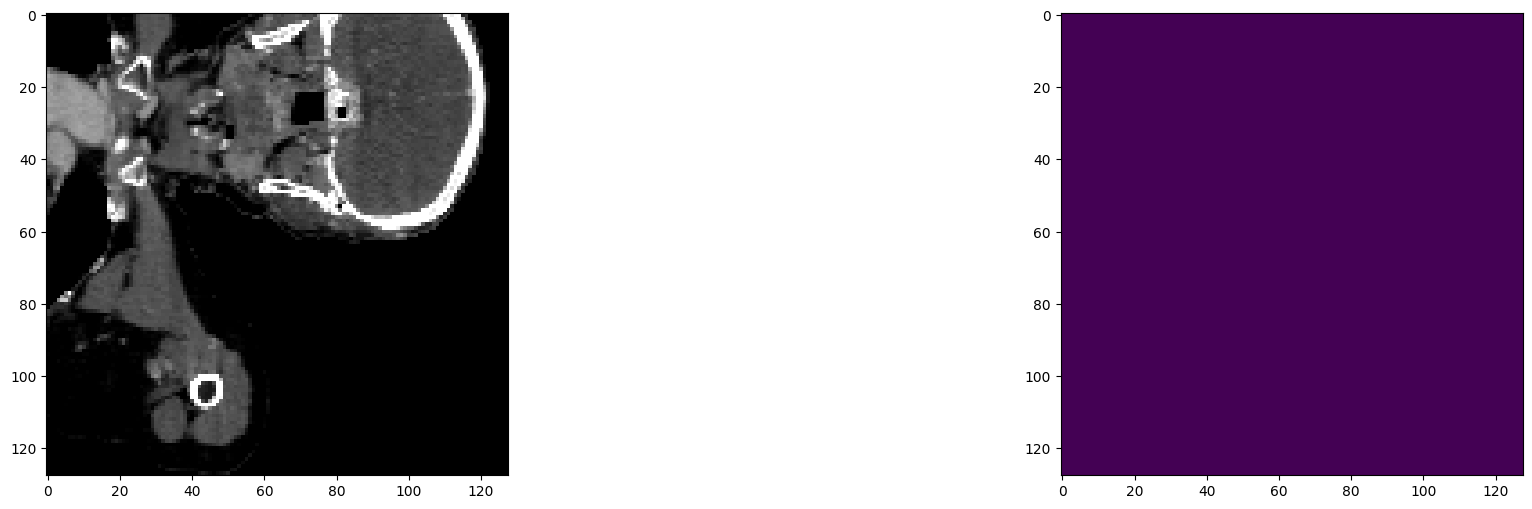

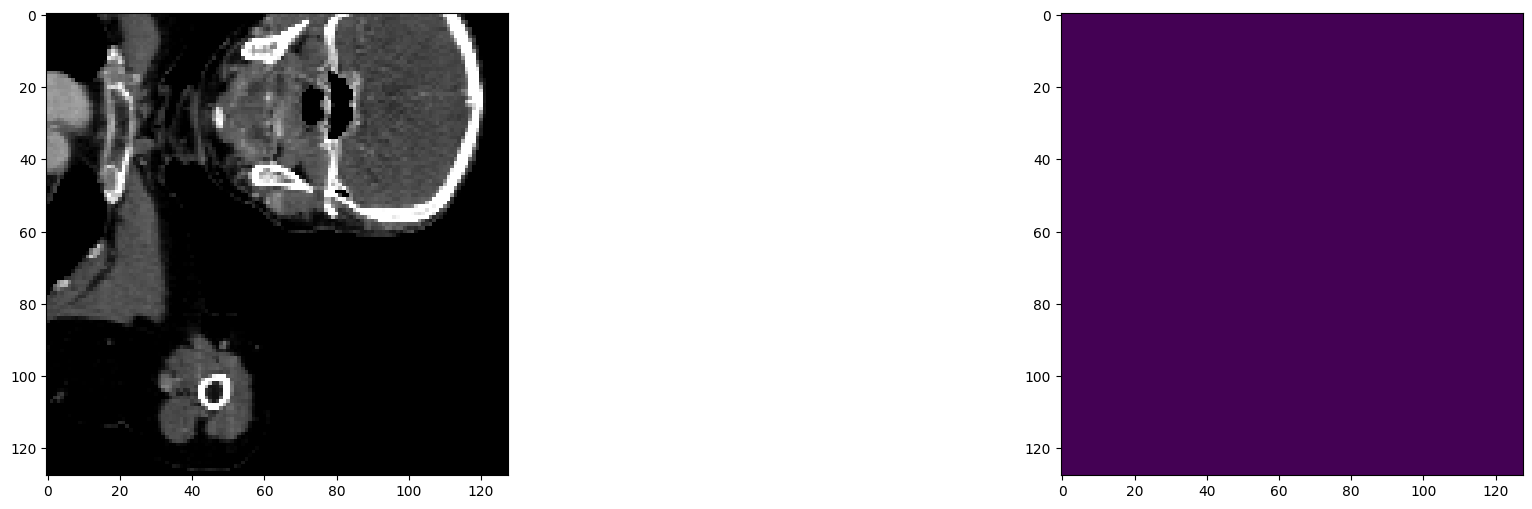

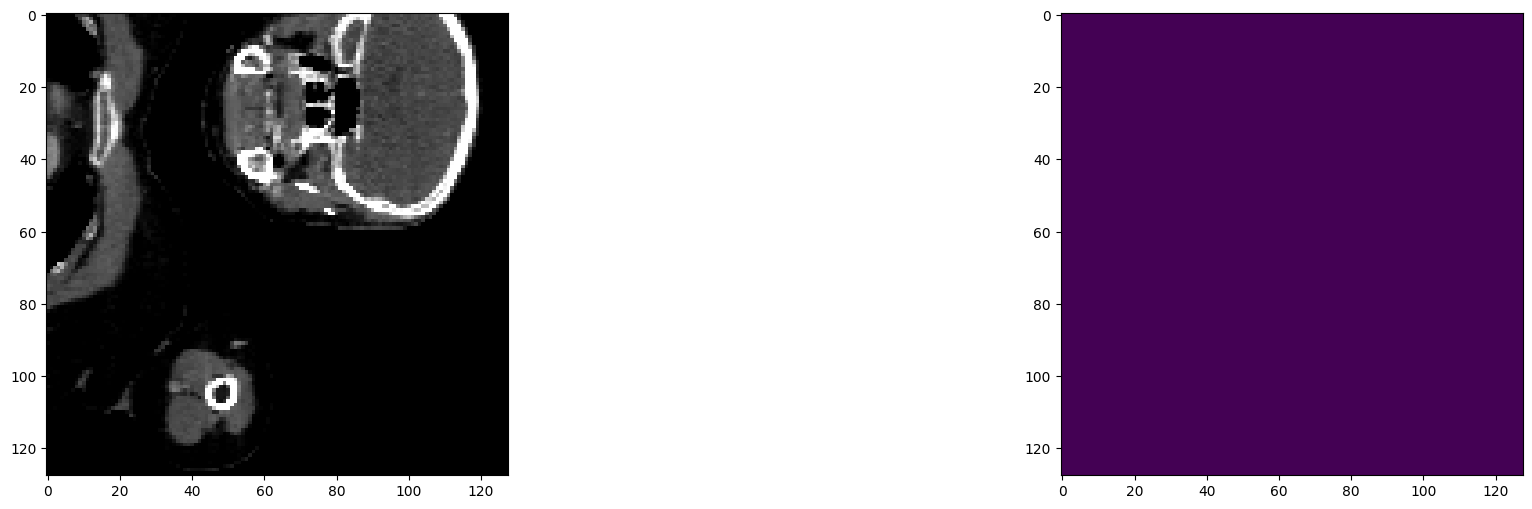

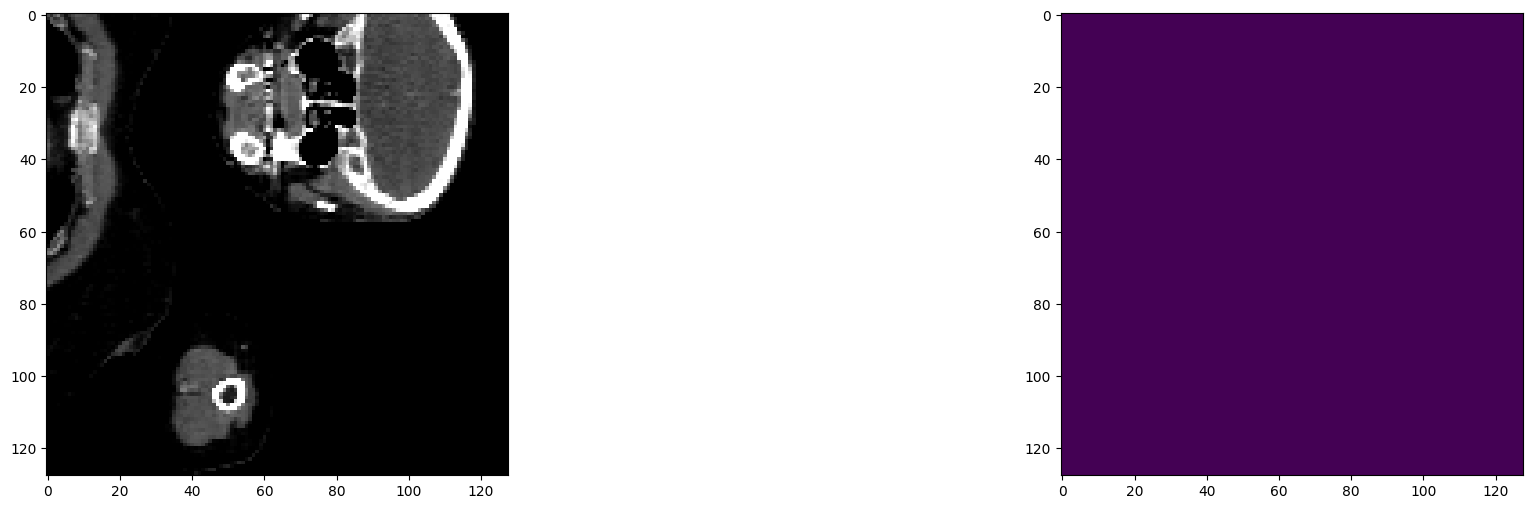

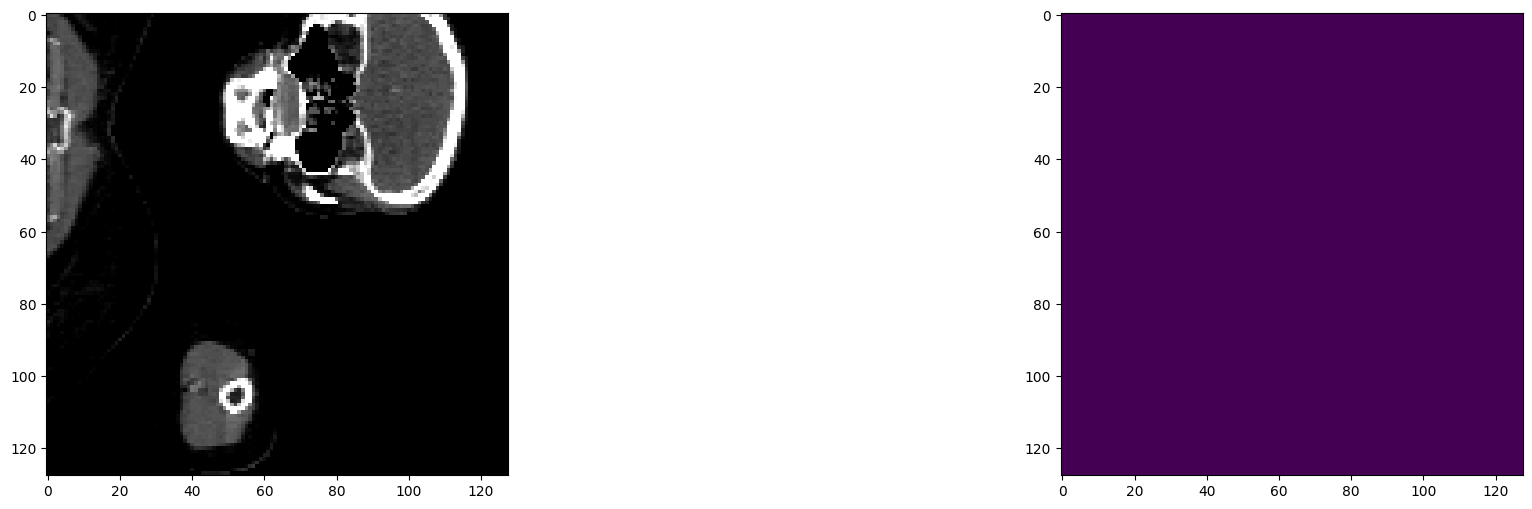

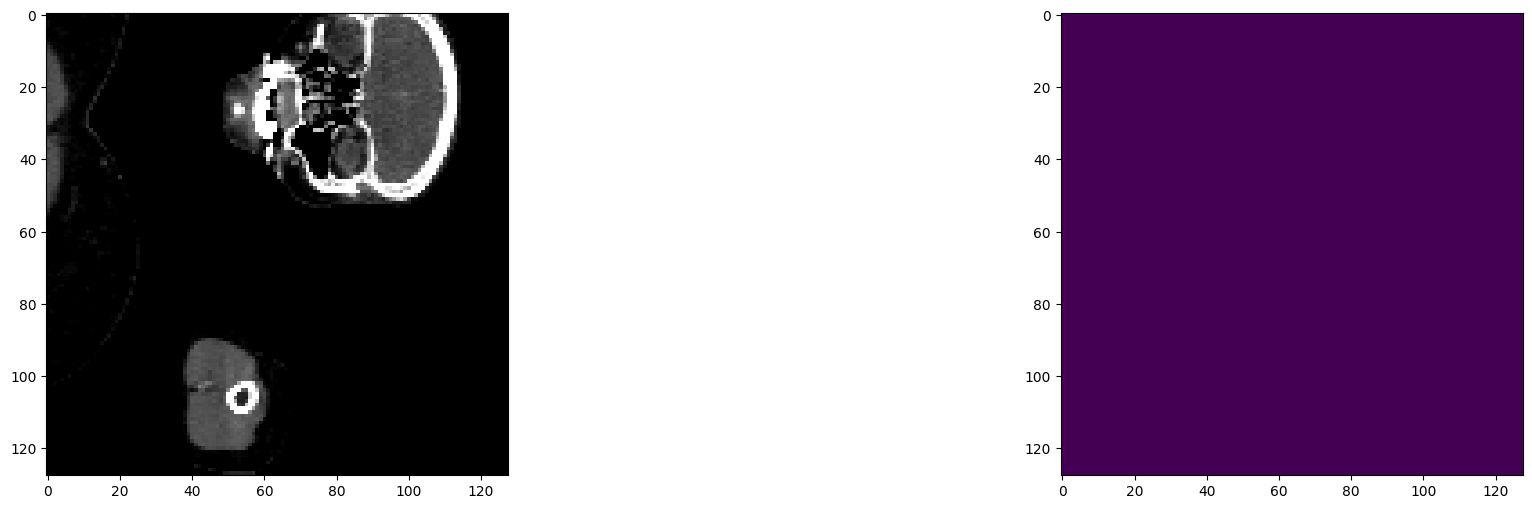

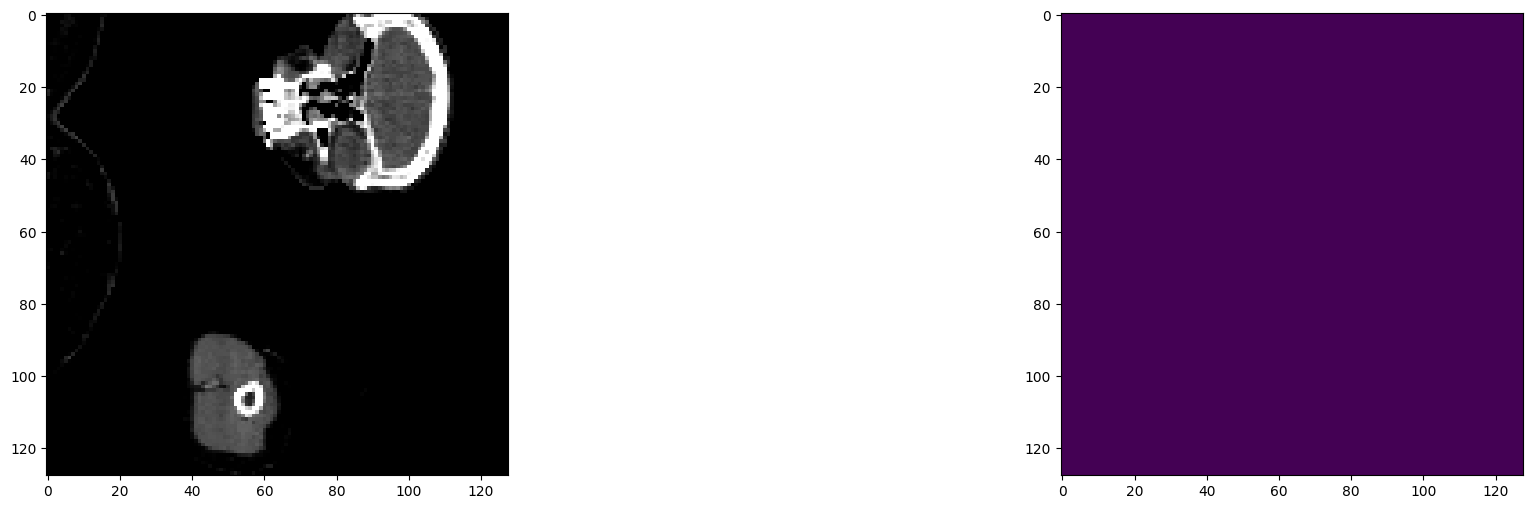

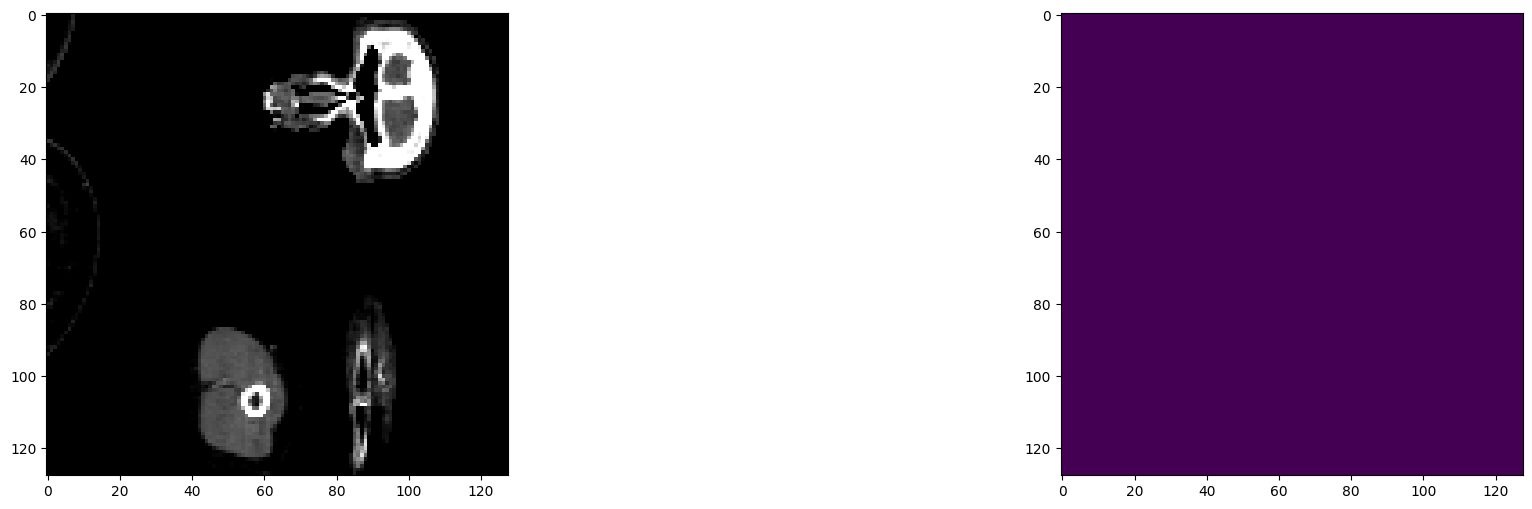

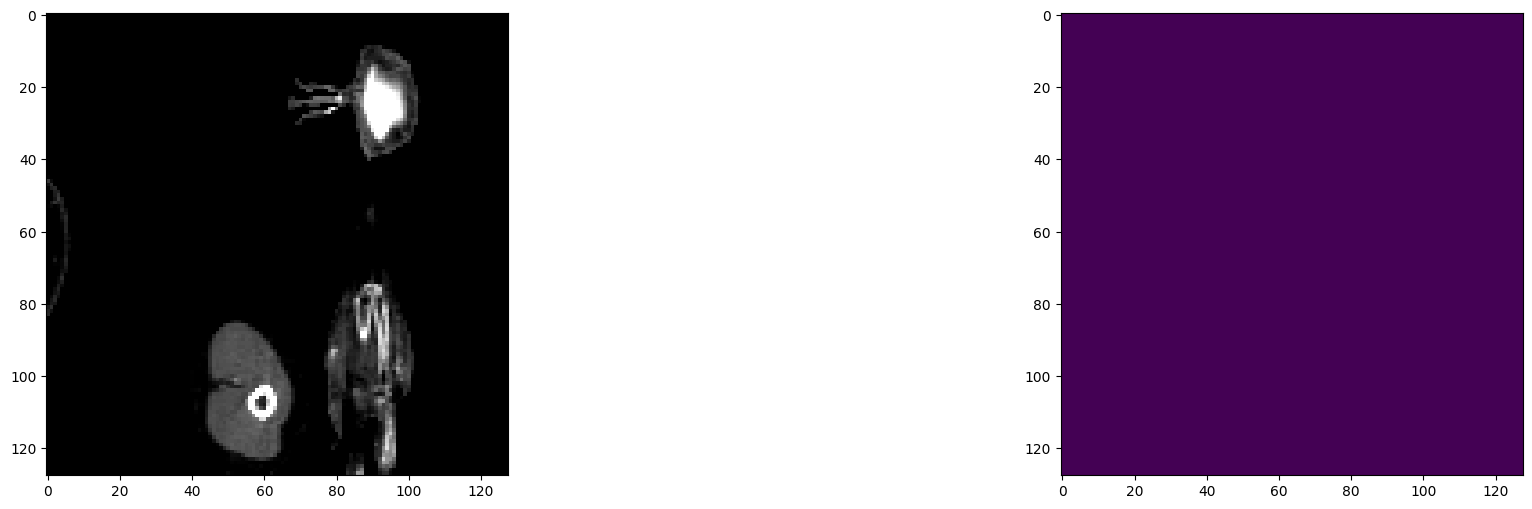

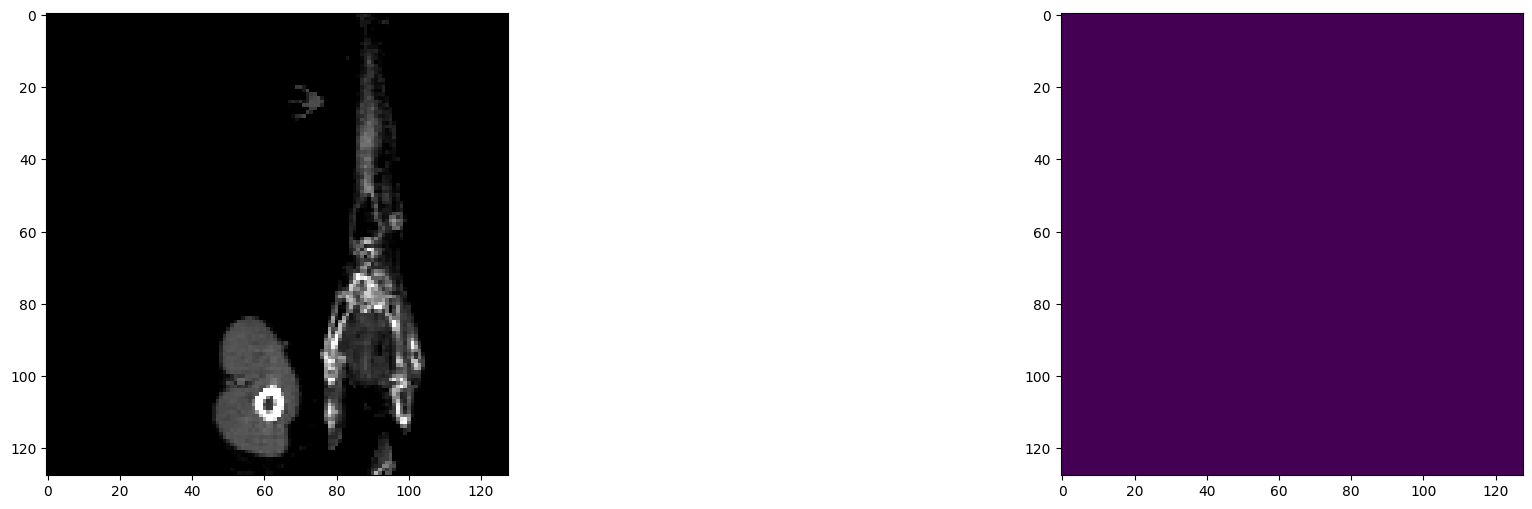

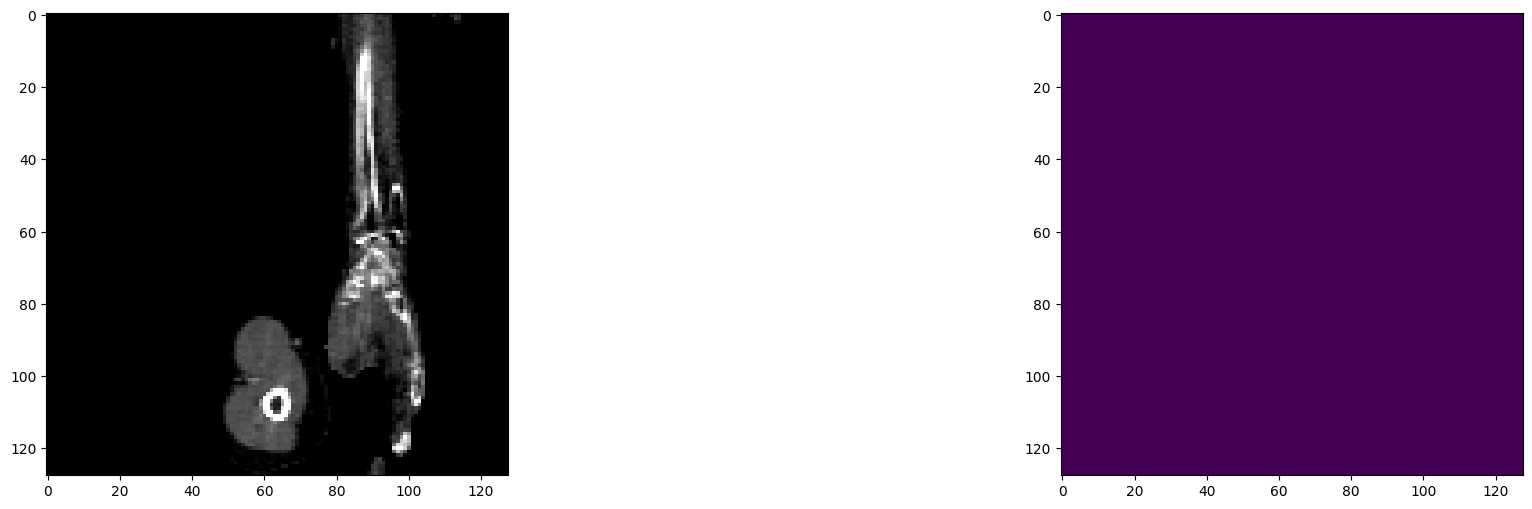

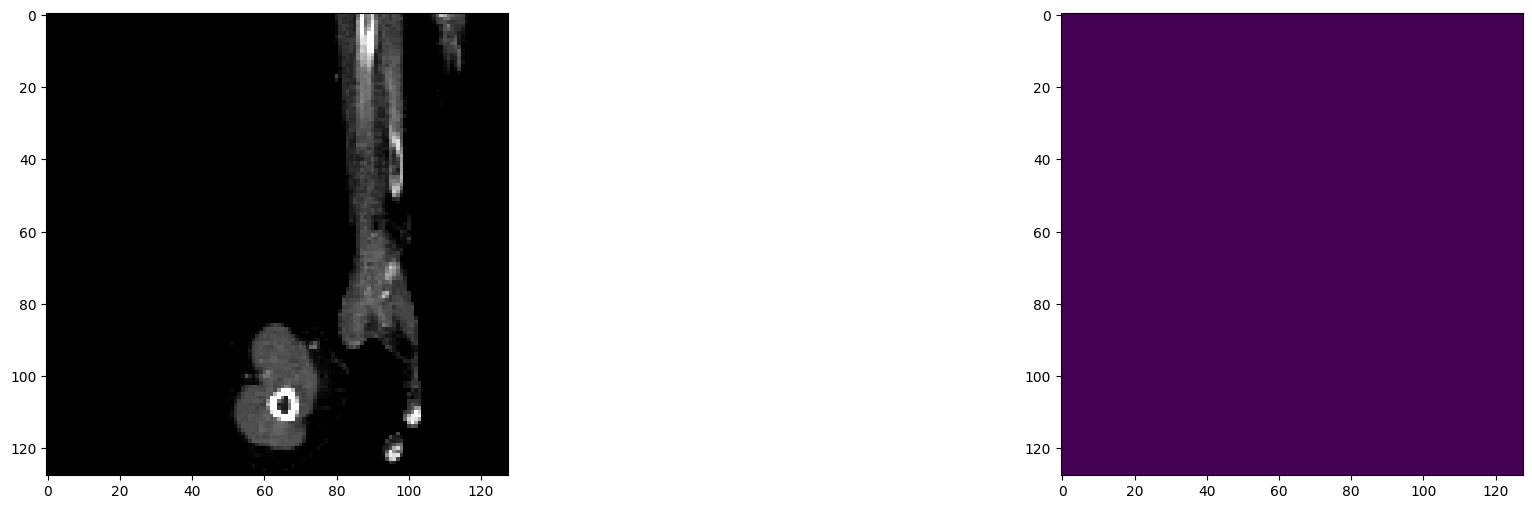

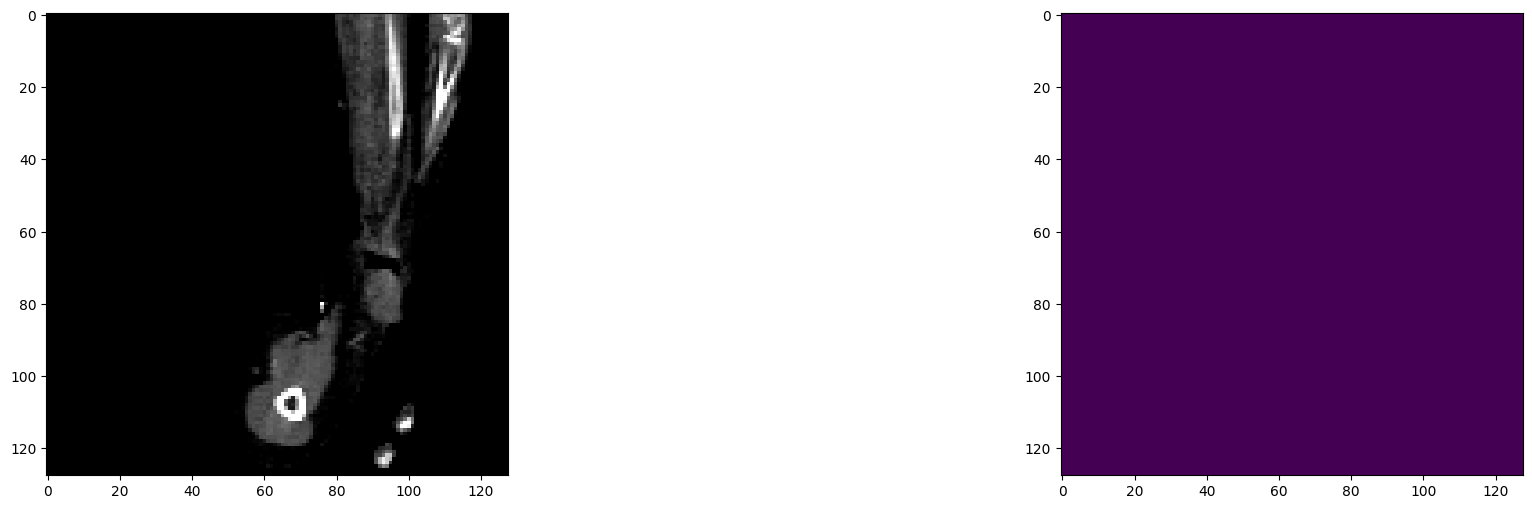

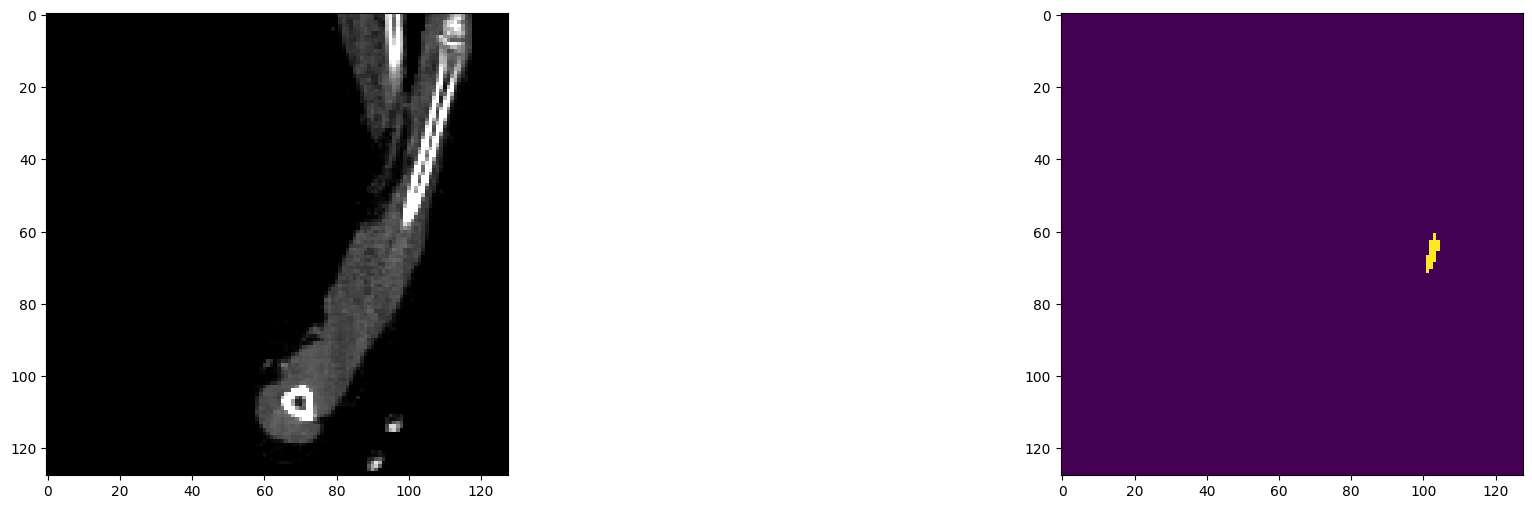

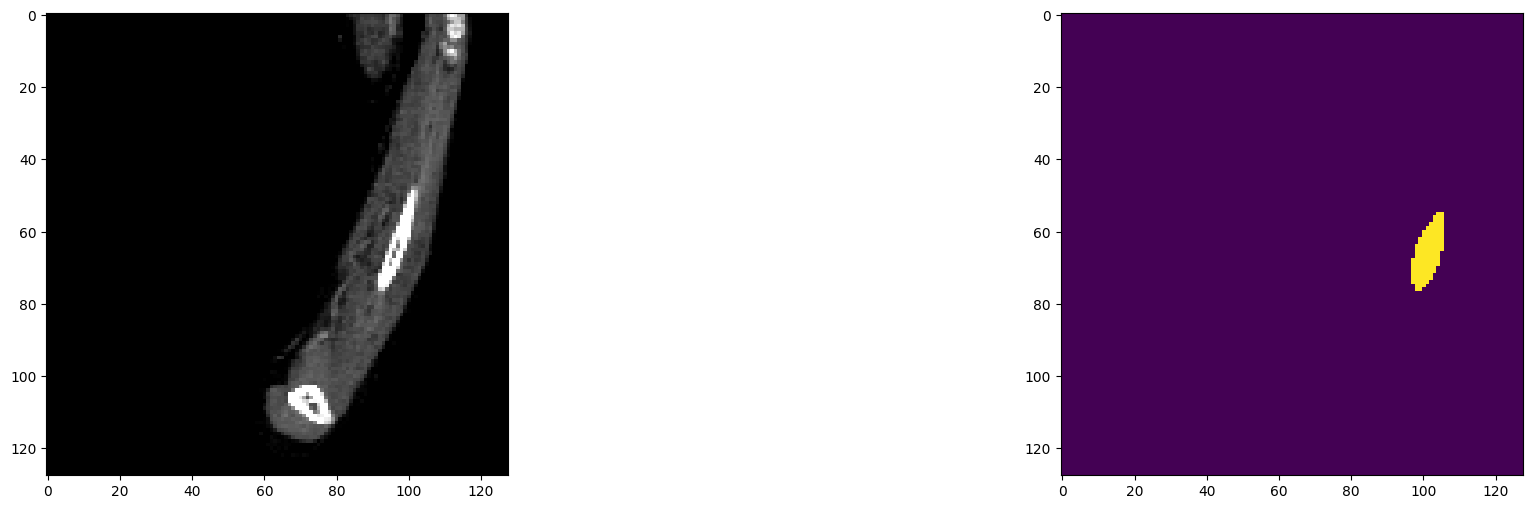

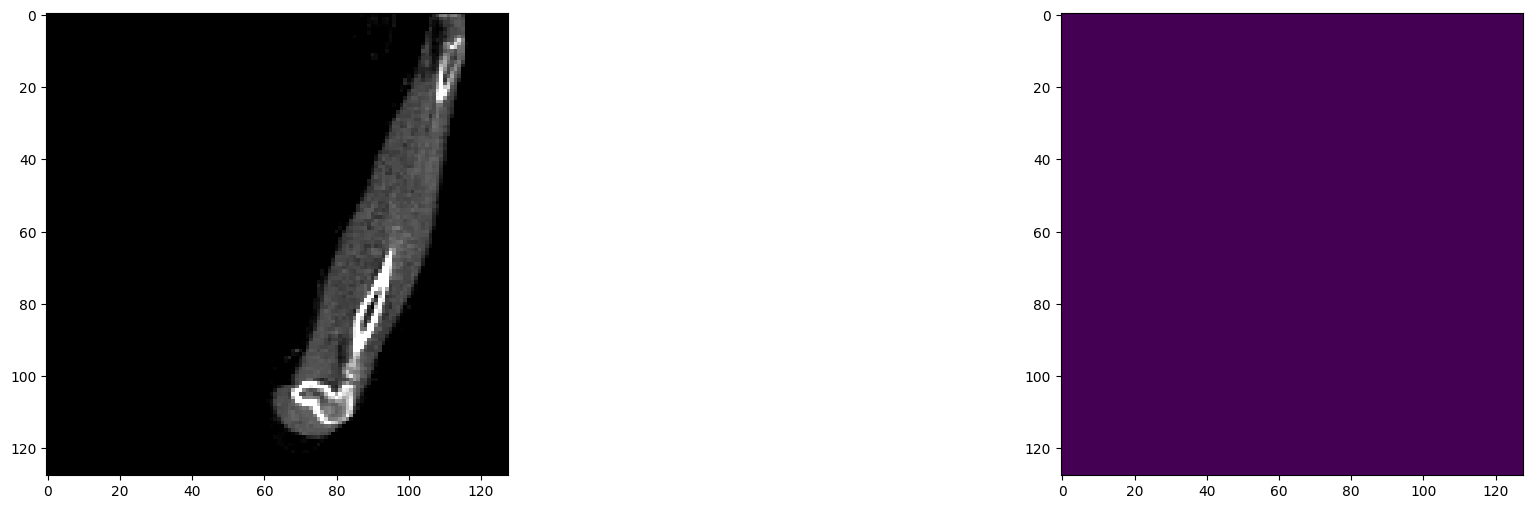

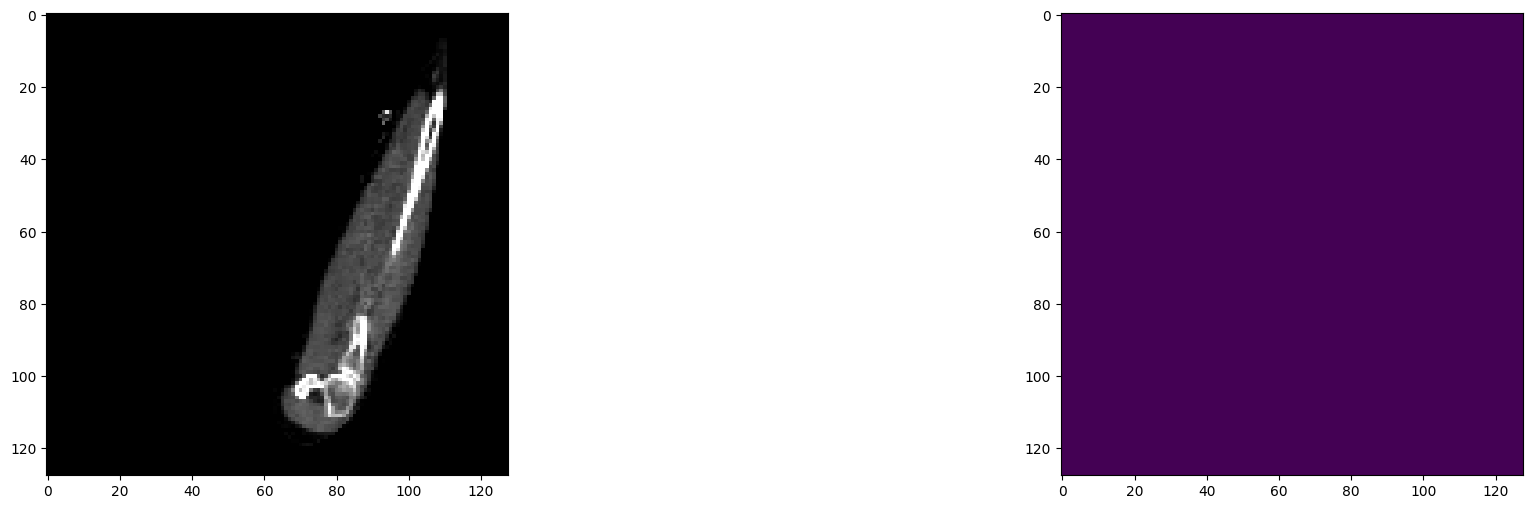

In [99]:
mask_volume = torch.sum(cropped['label'][0])
print(f'GT mask volumne {mask_volume}')

mask_cropper = RandCropByPosNegLabeld(keys=all_keys, label_key='label', spatial_size=(128,128,128), pos=1, neg=0.2, num_samples=1,
                       image_key='image', image_threshold=0)
maskCrop_list = mask_cropper(cropped)

for one in maskCrop_list:
    image, label = one['image'], one['label']
    print(image.shape, label.shape)
    print(f'cropped GT volumne: {torch.sum(label[0])}')
    for iter in range(24):
        plt.figure(figsize=(24,6))

        plt.subplot(1, 2, 1)
        plt.imshow(image[0][:, iter*5, :].detach().cpu(), cmap='gray')

        plt.subplot(1, 2, 2)
        plt.imshow(label[0][:, iter*5, :].detach().cpu())
    



In [104]:
all_keys = ['ct','pet','label']

train_transform = Compose([
    LoadImaged(keys=all_keys, ensure_channel_first=True),
    EnsureTyped(keys=all_keys, track_meta=False),
    Orientationd(keys=all_keys, axcodes='RAS'),
    ScaleIntensityRanged(keys='ct', a_min=-100, a_max=400,
                         b_min=0, b_max=1, clip=True),
    ScaleIntensityRanged(keys='pet', a_min=0, a_max=70,
                         b_min=0, b_max=1, clip=True),
    CropForegroundd(keys=all_keys, source_key='pet'),
    RandCropByPosNegLabeld(keys=all_keys, label_key='label', spatial_size=(128,128,128),
                           pos=1, neg=0.2, num_samples=1,
                            image_key='pet', image_threshold=0)
])


origind = {'ct':f'{target}/CTres.nii.gz',
           'pet':f'{target}/SUV.nii.gz',
          'label':f'{target}/SEG.nii.gz'}

transformed = train_transform(origind)[0]

/opt/conda/envs/autoPET/lib/python3.10/site-packages/monai/transforms/spatial/array.py:692: UserWarning: `data_array` is not of type `MetaTensor, assuming affine to be identity.
  warnings.warn("`data_array` is not of type `MetaTensor, assuming affine to be identity.")


torch.Size([128, 128, 128]) torch.Size([128, 128, 128]) torch.Size([128, 128, 128])
GT volume size: tensor(442.)


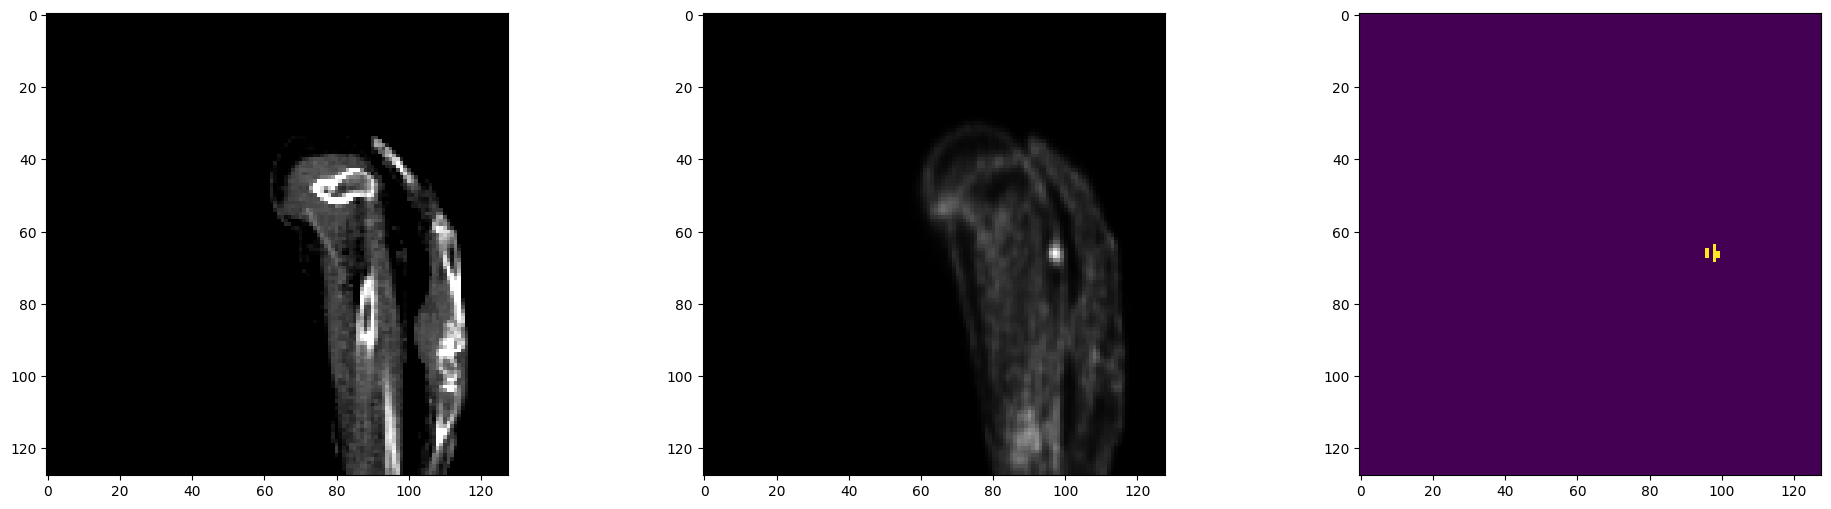

In [111]:
ct, pet, label = transformed['ct'], transformed['pet'], transformed['label']

print(ct[0].shape, pet[0].shape, label[0].shape)

plt.figure(figsize=(24,6))

plt.subplot(1, 3, 1)
plt.imshow(ct[0][:, 62, :].detach().cpu(), cmap='gray')

plt.subplot(1, 3, 2)
plt.imshow(pet[0][:, 62, :].detach().cpu(), cmap='gray')

plt.subplot(1, 3, 3)
plt.imshow(label[0][:, 62, :].detach().cpu())

print(f'GT volume size: {torch.sum(label[0])}')
print(f'CT image scale: [{torch.min(ct[0])}, {torch.max(ct[0])}], unique:{len(torch.unique(ct[0]))}---{torch.unique(ct[0])} ')
print(f'PET image scale: [{torch.min(ct[0])}, {torch.max(ct[0])}], unique:{len(torch.unique(ct[0]))}---{torch.unique(ct[0])} ')